<a href="https://colab.research.google.com/github/VLCHS/FCNN/blob/FCNN/Training_FCNN_p_pi0%26results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Started

In [9]:
!pip install --q wandb==0.18.7
!pip install --q wandb[media]
!pip install --q torch==2.5.1
!pip install --q lightning==2.4.0
!pip install --q featuretools

In [10]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import featuretools as ft

from scipy import spatial
from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanSquaredError
from torchmetrics import R2Score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)

set_random_seed(42)

INFO: Seed set to 42


2024-12-11 10:55:04,525 : INFO : Seed set to 42


In [ ]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [4]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [5]:
# Load the data Ebeam = [1.64 2.44 5.75 2.04]
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
df = df[df['error'] <= df["error"].quantile(0.98)]
df = df.drop(df[df['dsigma_dOmega'] == 0].index)
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912000,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175000,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650000,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560000,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130000,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
72238,2.04,1.7875,0.65,0.9,4.581489,0.485355,0.093559,-0.130526,-0.991445
72239,2.04,1.7875,0.65,0.9,4.843289,0.528385,0.083915,0.130526,-0.991445
72240,2.04,1.7875,0.65,0.9,5.105088,0.497479,0.107885,0.382683,-0.923880
72241,2.04,1.7875,0.65,0.9,5.366887,2.774690,2.426200,0.608761,-0.793353


Text(0, 0.5, 'Q^2, GeV^2')

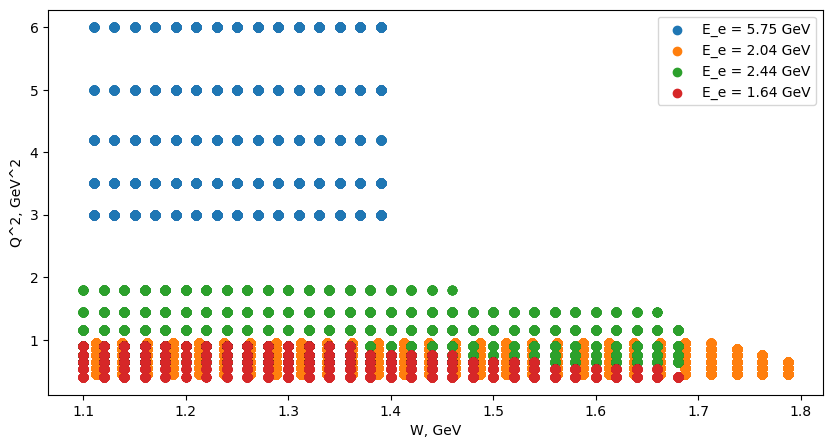

In [6]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#TRAINING

In [7]:
# Initialize wandb
run = wandb.init(project="FCNN for ep->ep_pi0, unified topology")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [11]:
class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))

#params
project_name = "FCNN for ep->ep_pi0, unified topology"

logger_path = './wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'feature_engineering': False,
    'scale_data': False,
    'feature_scaler': StandardScaler(),   #Standard and MinMax are pretty good
    'label_scaler': StandardScaler(),
    'augment': False,
    'augment_factor': 2,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],  #the 1st layer is 6 or 37
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': LogCoshLoss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 200,
    'es_min_delta': 1e-05,
    'es_patience': 20,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm_phi = np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi)
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': augm_phi,
                           'cos_phi': math.cos(augm_phi),
                           'sin_phi': math.sin(augm_phi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           #'reaction_type': new_augm.reaction_type,
                          })
        return augm

    def feature_engineering(self, df):
        df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
        es = ft.EntitySet(id="data")
        es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                              trans_primitives = ['add_numeric', 'multiply_numeric'])

        df_after_feature_eng = feature_matrix.copy()
        #df_after_feature_eng['reaction_type'] = df['reaction_type']
        return df_after_feature_eng


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0, reaction_type=1
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
        #df_p = df_p[df_p['dsigma_dOmega'] <= df_p["dsigma_dOmega"].quantile(0.97)]   #PREPROCESSING
        #df_p = df_p[df_p['error'] <= df_p["error"].quantile(0.98)]                   #PREPROCESSING
        #df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)                     #PREPROCESSING
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+, reaction_type=0
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)
        self.df = df

        feature_columns = list(df.columns)
        feature_columns.remove('dsigma_dOmega')
        feature_data = df[feature_columns]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            train_df = pd.concat([train_feature_data, train_label_data], axis=1)
            aug_series_list = []
            for i in tqdm.tqdm(train_df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            augment_train_df = pd.concat([train_df, aug_df], ignore_index=True)
            train_label_data = augment_train_df["dsigma_dOmega"]
            train_feature_data = augment_train_df.loc[:, ~augment_train_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass

        # DELETING PHI AND ERROR FROM FEATURES
        train_feature_data = train_feature_data.reset_index(drop=True)
        val_feature_data = val_feature_data.reset_index(drop=True)
        train_feature_data = train_feature_data.loc[:, ~train_feature_data.columns.isin(["phi", "error"])]
        val_feature_data = val_feature_data.loc[:, ~val_feature_data.columns.isin(["phi", "error"])]


        # FEATURE ENGINEERING
        if self.hyperparams.get('feature_engineering'):
            train_feature_data = self.feature_engineering(train_feature_data)
            val_feature_data = self.feature_engineering(val_feature_data)
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            #columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=2)

class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

In [12]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator=device,
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: GPU available: False, used: False


2024-12-11 10:55:05,212 : INFO : GPU available: False, used: False


INFO: TPU available: False, using: 0 TPU cores


2024-12-11 10:55:05,227 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2024-12-11 10:55:05,237 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2024-12-11 10:55:05,254 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | LogCoshLoss         | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


2024-12-11 10:55:06,464 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | LogCoshLoss         | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode
2024-12-11 10:55:06,572 : INFO : Training is starting
2024-12-11 10:56:35,398 : INFO : epoch: 0; val_loss: 1.114426612854004
2024-1

INFO: Metric val_loss improved. New best score: 1.114


2024-12-11 10:56:35,511 : INFO : Metric val_loss improved. New best score: 1.114
2024-12-11 10:56:35,778 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=1.11443-epoch=00.ckpt
2024-12-11 10:57:44,019 : INFO : epoch: 1; val_loss: 0.781251847743988
2024-12-11 10:57:44,033 : INFO : epoch: 1; train_loss: 1.0087133646011353


INFO: Metric val_loss improved by 0.333 >= min_delta = 1e-05. New best score: 0.781


2024-12-11 10:57:44,099 : INFO : Metric val_loss improved by 0.333 >= min_delta = 1e-05. New best score: 0.781
2024-12-11 10:57:44,401 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.78125-epoch=01.ckpt
2024-12-11 10:59:07,779 : INFO : epoch: 2; val_loss: 0.6942415833473206
2024-12-11 10:59:07,794 : INFO : epoch: 2; train_loss: 0.5955869555473328


INFO: Metric val_loss improved by 0.087 >= min_delta = 1e-05. New best score: 0.694


2024-12-11 10:59:07,862 : INFO : Metric val_loss improved by 0.087 >= min_delta = 1e-05. New best score: 0.694
2024-12-11 10:59:08,049 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.69424-epoch=02.ckpt
2024-12-11 11:00:31,183 : INFO : epoch: 3; val_loss: 0.5267457365989685
2024-12-11 11:00:31,198 : INFO : epoch: 3; train_loss: 0.5133861899375916


INFO: Metric val_loss improved by 0.167 >= min_delta = 1e-05. New best score: 0.527


2024-12-11 11:00:31,265 : INFO : Metric val_loss improved by 0.167 >= min_delta = 1e-05. New best score: 0.527
2024-12-11 11:00:31,533 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.52675-epoch=03.ckpt
2024-12-11 11:01:57,945 : INFO : epoch: 4; val_loss: 0.5020153522491455
2024-12-11 11:01:57,958 : INFO : epoch: 4; train_loss: 0.4583261013031006


INFO: Metric val_loss improved by 0.025 >= min_delta = 1e-05. New best score: 0.502


2024-12-11 11:01:58,028 : INFO : Metric val_loss improved by 0.025 >= min_delta = 1e-05. New best score: 0.502
2024-12-11 11:01:58,241 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.50202-epoch=04.ckpt
2024-12-11 11:03:23,366 : INFO : epoch: 5; val_loss: 0.4039766192436218
2024-12-11 11:03:23,382 : INFO : epoch: 5; train_loss: 0.43049201369285583


INFO: Metric val_loss improved by 0.098 >= min_delta = 1e-05. New best score: 0.404


2024-12-11 11:03:23,466 : INFO : Metric val_loss improved by 0.098 >= min_delta = 1e-05. New best score: 0.404
2024-12-11 11:03:23,711 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.40398-epoch=05.ckpt
2024-12-11 11:04:49,847 : INFO : epoch: 6; val_loss: 0.33048945665359497
2024-12-11 11:04:49,861 : INFO : epoch: 6; train_loss: 0.42279958724975586


INFO: Metric val_loss improved by 0.073 >= min_delta = 1e-05. New best score: 0.330


2024-12-11 11:04:49,937 : INFO : Metric val_loss improved by 0.073 >= min_delta = 1e-05. New best score: 0.330
2024-12-11 11:04:50,147 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.33049-epoch=06.ckpt
2024-12-11 11:06:14,703 : INFO : epoch: 7; val_loss: 0.4433959126472473
2024-12-11 11:06:14,717 : INFO : epoch: 7; train_loss: 0.39392638206481934
2024-12-11 11:06:14,959 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.44340-epoch=07.ckpt
2024-12-11 11:07:41,294 : INFO : epoch: 8; val_loss: 0.37816596031188965
2024-12-11 11:07:41,310 : INFO : epoch: 8; train_loss: 0.3814483880996704
2024-12-11 11:07:41,526 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.37817-epoch=08.ckpt
2024-12-11 11:09:06,294 : INFO : epoch: 9; val_loss: 0.483312

INFO: Metric val_loss improved by 0.041 >= min_delta = 1e-05. New best score: 0.290


2024-12-11 11:11:57,740 : INFO : Metric val_loss improved by 0.041 >= min_delta = 1e-05. New best score: 0.290
2024-12-11 11:11:58,000 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.28977-epoch=11.ckpt
2024-12-11 11:13:22,053 : INFO : epoch: 12; val_loss: 0.29150012135505676
2024-12-11 11:13:22,070 : INFO : epoch: 12; train_loss: 0.31840670108795166
2024-12-11 11:13:22,388 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.29150-epoch=12.ckpt
2024-12-11 11:14:47,162 : INFO : epoch: 13; val_loss: 0.30759382247924805
2024-12-11 11:14:47,177 : INFO : epoch: 13; train_loss: 0.3085547685623169
2024-12-11 11:14:47,395 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.30759-epoch=13.ckpt
2024-12-11 11:16:12,796 : INFO : epoch: 14; val_loss: 0.

INFO: Metric val_loss improved by 0.008 >= min_delta = 1e-05. New best score: 0.282


2024-12-11 11:20:29,127 : INFO : Metric val_loss improved by 0.008 >= min_delta = 1e-05. New best score: 0.282
2024-12-11 11:20:29,456 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.28201-epoch=17.ckpt
2024-12-11 11:21:55,108 : INFO : epoch: 18; val_loss: 0.28512635827064514
2024-12-11 11:21:55,129 : INFO : epoch: 18; train_loss: 0.3122636079788208
2024-12-11 11:21:55,719 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.28513-epoch=18.ckpt
2024-12-11 11:23:22,131 : INFO : epoch: 19; val_loss: 0.32783228158950806
2024-12-11 11:23:22,151 : INFO : epoch: 19; train_loss: 0.29836148023605347
2024-12-11 11:24:47,420 : INFO : epoch: 20; val_loss: 0.3552052974700928
2024-12-11 11:24:47,436 : INFO : epoch: 20; train_loss: 0.30834898352622986
2024-12-11 11:26:12,605 : INFO : epoch: 21; val_loss: 0.43636441230773926
2024-12-11 

INFO: Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.276


2024-12-11 11:31:59,491 : INFO : Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.276
2024-12-11 11:31:59,888 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.27617-epoch=25.ckpt
2024-12-11 11:33:25,158 : INFO : epoch: 26; val_loss: 0.29326382279396057
2024-12-11 11:33:25,172 : INFO : epoch: 26; train_loss: 0.28942275047302246
2024-12-11 11:34:50,083 : INFO : epoch: 27; val_loss: 0.35020333528518677
2024-12-11 11:34:50,096 : INFO : epoch: 27; train_loss: 0.2959166169166565
2024-12-11 11:36:15,050 : INFO : epoch: 28; val_loss: 0.7498832941055298
2024-12-11 11:36:15,064 : INFO : epoch: 28; train_loss: 0.29646098613739014
2024-12-11 11:37:43,359 : INFO : epoch: 29; val_loss: 0.27783387899398804
2024-12-11 11:37:43,375 : INFO : epoch: 29; train_loss: 0.33597832918167114
2024-12-11 11:37:43,917 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/dail

INFO: Metric val_loss improved by 0.022 >= min_delta = 1e-05. New best score: 0.254


2024-12-11 11:39:09,277 : INFO : Metric val_loss improved by 0.022 >= min_delta = 1e-05. New best score: 0.254
2024-12-11 11:39:09,640 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.25425-epoch=30.ckpt
2024-12-11 11:40:34,502 : INFO : epoch: 31; val_loss: 0.25287193059921265
2024-12-11 11:40:34,515 : INFO : epoch: 31; train_loss: 0.2716738283634186


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.253


2024-12-11 11:40:34,583 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.253
2024-12-11 11:40:34,833 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.25287-epoch=31.ckpt
2024-12-11 11:42:02,325 : INFO : epoch: 32; val_loss: 0.3364338278770447
2024-12-11 11:42:02,339 : INFO : epoch: 32; train_loss: 0.27425408363342285
2024-12-11 11:43:27,594 : INFO : epoch: 33; val_loss: 0.2637651264667511
2024-12-11 11:43:27,615 : INFO : epoch: 33; train_loss: 0.2739264965057373
2024-12-11 11:43:28,077 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.26377-epoch=33.ckpt
2024-12-11 11:44:53,553 : INFO : epoch: 34; val_loss: 0.2569417357444763
2024-12-11 11:44:53,566 : INFO : epoch: 34; train_loss: 0.26769986748695374
2024-12-11 11:44:53,924 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_

INFO: Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.247


2024-12-11 12:05:15,013 : INFO : Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.247
2024-12-11 12:05:15,204 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24699-epoch=48.ckpt
2024-12-11 12:06:40,934 : INFO : epoch: 49; val_loss: 0.3082633912563324
2024-12-11 12:06:40,948 : INFO : epoch: 49; train_loss: 0.2547035813331604
2024-12-11 12:08:09,004 : INFO : epoch: 50; val_loss: 0.2703617215156555
2024-12-11 12:08:09,020 : INFO : epoch: 50; train_loss: 0.25911781191825867
2024-12-11 12:09:34,430 : INFO : epoch: 51; val_loss: 0.24973224103450775
2024-12-11 12:09:34,447 : INFO : epoch: 51; train_loss: 0.25143349170684814
2024-12-11 12:09:34,728 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24973-epoch=51.ckpt
2024-12-11 12:11:01,077 : INFO : epoch: 52; val_loss: 0.25365981459617615
2024-12-11 1

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.247


2024-12-11 12:29:57,797 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.247
2024-12-11 12:29:57,999 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24689-epoch=65.ckpt
2024-12-11 12:31:23,754 : INFO : epoch: 66; val_loss: 0.2482450157403946
2024-12-11 12:31:23,768 : INFO : epoch: 66; train_loss: 0.2432985156774521
2024-12-11 12:32:51,096 : INFO : epoch: 67; val_loss: 0.24641963839530945
2024-12-11 12:32:51,112 : INFO : epoch: 67; train_loss: 0.2420566827058792


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.246


2024-12-11 12:32:51,194 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.246
2024-12-11 12:32:51,498 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24642-epoch=67.ckpt
2024-12-11 12:34:19,245 : INFO : epoch: 68; val_loss: 0.25316381454467773
2024-12-11 12:34:19,259 : INFO : epoch: 68; train_loss: 0.24445126950740814
2024-12-11 12:35:45,559 : INFO : epoch: 69; val_loss: 0.2498289793729782
2024-12-11 12:35:45,575 : INFO : epoch: 69; train_loss: 0.24399468302726746
2024-12-11 12:37:14,922 : INFO : epoch: 70; val_loss: 0.2482701987028122
2024-12-11 12:37:14,941 : INFO : epoch: 70; train_loss: 0.24282340705394745
2024-12-11 12:38:41,747 : INFO : epoch: 71; val_loss: 0.24429039657115936
2024-12-11 12:38:41,760 : INFO : epoch: 71; train_loss: 0.24422745406627655


INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.244


2024-12-11 12:38:41,825 : INFO : Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.244
2024-12-11 12:38:42,062 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24429-epoch=71.ckpt
2024-12-11 12:40:08,914 : INFO : epoch: 72; val_loss: 0.24464720487594604
2024-12-11 12:40:08,931 : INFO : epoch: 72; train_loss: 0.24187010526657104
2024-12-11 12:40:09,328 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24465-epoch=72.ckpt
2024-12-11 12:41:38,142 : INFO : epoch: 73; val_loss: 0.2459385246038437
2024-12-11 12:41:38,157 : INFO : epoch: 73; train_loss: 0.2448166459798813
2024-12-11 12:41:38,455 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24594-epoch=73.ckpt
2024-12-11 12:43:08,165 : INFO : epoch: 74; val_loss: 0.2

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.244


2024-12-11 12:44:36,363 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.244
2024-12-11 12:44:36,688 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24428-epoch=75.ckpt
2024-12-11 12:46:05,657 : INFO : epoch: 76; val_loss: 0.2492384910583496
2024-12-11 12:46:05,672 : INFO : epoch: 76; train_loss: 0.24174091219902039
2024-12-11 12:47:35,149 : INFO : epoch: 77; val_loss: 0.2514556050300598
2024-12-11 12:47:35,163 : INFO : epoch: 77; train_loss: 0.2438044548034668
2024-12-11 12:49:05,026 : INFO : epoch: 78; val_loss: 0.24433231353759766
2024-12-11 12:49:05,041 : INFO : epoch: 78; train_loss: 0.24387583136558533
2024-12-11 12:49:05,356 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24433-epoch=78.ckpt
2024-12-11 12:50:34,284 : INFO : epoch: 79; val_loss: 0.2462671995162964
2024-12-11 12

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.244


2024-12-11 12:55:04,396 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.244
2024-12-11 12:55:04,755 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24358-epoch=82.ckpt
2024-12-11 12:56:35,324 : INFO : epoch: 83; val_loss: 0.24696439504623413
2024-12-11 12:56:35,340 : INFO : epoch: 83; train_loss: 0.23816660046577454
2024-12-11 12:58:08,287 : INFO : epoch: 84; val_loss: 0.24353300034999847
2024-12-11 12:58:08,309 : INFO : epoch: 84; train_loss: 0.2370561957359314


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.244


2024-12-11 12:58:08,410 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.244
2024-12-11 12:58:08,766 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24353-epoch=84.ckpt
2024-12-11 12:59:38,716 : INFO : epoch: 85; val_loss: 0.24343818426132202
2024-12-11 12:59:38,729 : INFO : epoch: 85; train_loss: 0.23788252472877502


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.243


2024-12-11 12:59:38,808 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.243
2024-12-11 12:59:39,073 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24344-epoch=85.ckpt
2024-12-11 13:01:10,030 : INFO : epoch: 86; val_loss: 0.24627801775932312
2024-12-11 13:01:10,051 : INFO : epoch: 86; train_loss: 0.23827874660491943
2024-12-11 13:02:42,721 : INFO : epoch: 87; val_loss: 0.2478332668542862
2024-12-11 13:02:42,736 : INFO : epoch: 87; train_loss: 0.23868043720722198
2024-12-11 13:04:11,838 : INFO : epoch: 88; val_loss: 0.24263812601566315
2024-12-11 13:04:11,857 : INFO : epoch: 88; train_loss: 0.23956957459449768


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.243


2024-12-11 13:04:11,965 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.243
2024-12-11 13:04:12,278 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24264-epoch=88.ckpt
2024-12-11 13:05:47,155 : INFO : epoch: 89; val_loss: 0.24710115790367126
2024-12-11 13:05:47,168 : INFO : epoch: 89; train_loss: 0.23795537650585175
2024-12-11 13:07:17,846 : INFO : epoch: 90; val_loss: 0.243291437625885
2024-12-11 13:07:17,870 : INFO : epoch: 90; train_loss: 0.23773479461669922
2024-12-11 13:07:18,365 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24329-epoch=90.ckpt
2024-12-11 13:08:52,691 : INFO : epoch: 91; val_loss: 0.2469014674425125
2024-12-11 13:08:52,706 : INFO : epoch: 91; train_loss: 0.2389233410358429
2024-12-11 13:10:24,036 : INFO : epoch: 92; val_loss: 0.24404802918434143
2024-12-11 13

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.242


2024-12-11 13:24:29,125 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.242
2024-12-11 13:24:29,439 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24222-epoch=101.ckpt
2024-12-11 13:26:05,491 : INFO : epoch: 102; val_loss: 0.2419038563966751
2024-12-11 13:26:05,508 : INFO : epoch: 102; train_loss: 0.23577763140201569


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.242


2024-12-11 13:26:05,596 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.242
2024-12-11 13:26:05,929 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24190-epoch=102.ckpt
2024-12-11 13:27:41,464 : INFO : epoch: 103; val_loss: 0.24252265691757202
2024-12-11 13:27:41,481 : INFO : epoch: 103; train_loss: 0.23475347459316254
2024-12-11 13:27:41,881 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/daily-violet-21/checkpoints/exp_name=0val_loss=0.24252-epoch=103.ckpt
2024-12-11 13:29:19,599 : INFO : epoch: 104; val_loss: 0.2432679533958435
2024-12-11 13:29:19,613 : INFO : epoch: 104; train_loss: 0.2348850518465042
2024-12-11 13:30:55,836 : INFO : epoch: 105; val_loss: 0.24688544869422913
2024-12-11 13:30:55,851 : INFO : epoch: 105; train_loss: 0.23544102907180786
2024-12-11 13:32:32,532 : INFO : epoch: 106; val_loss: 0.24434751272201538
20

INFO: Monitored metric val_loss did not improve in the last 20 records. Best score: 0.242. Signaling Trainer to stop.


2024-12-11 13:59:06,943 : INFO : Monitored metric val_loss did not improve in the last 20 records. Best score: 0.242. Signaling Trainer to stop.
2024-12-11 13:59:06,951 : INFO : Training is ending


# PLOT CROSS SECTIONS & STRUCTURE FUNCTIONS

In [13]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    # feature engineering
    if model.hyperparams.get('feature_engineering'):
        def feature_engineering(df):
                df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
                es = ft.EntitySet(id="data")
                es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

                # Run deep feature synthesis with transformation primitives
                feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

                df_after_feature_eng = feature_matrix.copy()
                #df_after_feature_eng['reaction_type'] = df['reaction_type']
                return df_after_feature_eng

        df_grid_for_prediction = feature_engineering(df_grid)
    else:
        df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        #columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        #df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega_predicted'] = df_grid_for_prediction["dsigma_dOmega_predicted"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega_predicted"].to_frame())[:,0])
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values

    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             #label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             #label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data'
             #label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"AI prediction")

    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [14]:
df_for_plot = pd.DataFrame({
      'Ebeam': [1.64, 1.64, 2.04, 2.04, 2.44, 2.44, 5.75, 5.75],
      'W': [1.12, 1.48, 1.12, 1.12, 1.14, 1.56, 1.14, 1.32],
      'Q2': [0.65, 0.4, 0.95, 0.45, 0.9, 1.15, 3.0, 5.0],
      'cos_theta': [0.3, -0.1, -0.5, 0.5, 0.1, 0.1, -0.5, 0.1]
})
df_for_plot

,Ebeam,W,Q2,cos_theta
0,1.64,1.12,0.65,0.3
1,1.64,1.48,0.40,-0.1
2,2.04,1.12,0.95,-0.5
3,2.04,1.12,0.45,0.5
4,2.44,1.14,0.90,0.1
5,2.44,1.56,1.15,0.1
6,5.75,1.14,3.00,-0.5
7,5.75,1.32,5.00,0.1


100%|██████████| 157/157 [00:05<00:00, 27.58it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-13-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3622793807477293' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-13-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0135204607403956' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-inpu

2024-12-11 14:11:30,821 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2024-12-11 14:11:30,825 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
2024-12-11 14:11:30,827 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-11 14:11:30,840 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-11 14:11:30,848 : DEBUG : findfont: score(FontEntry(f

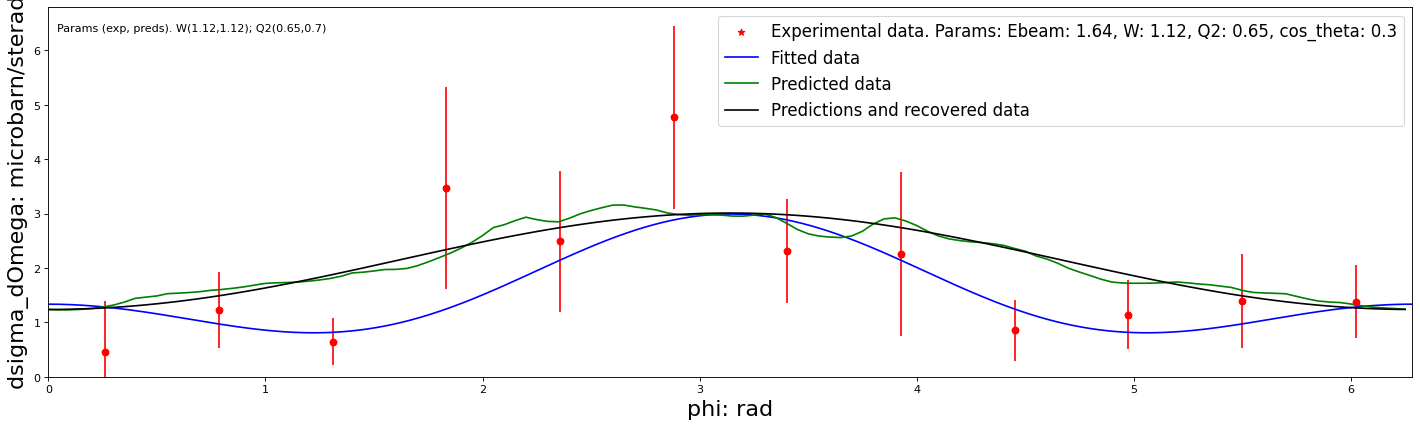

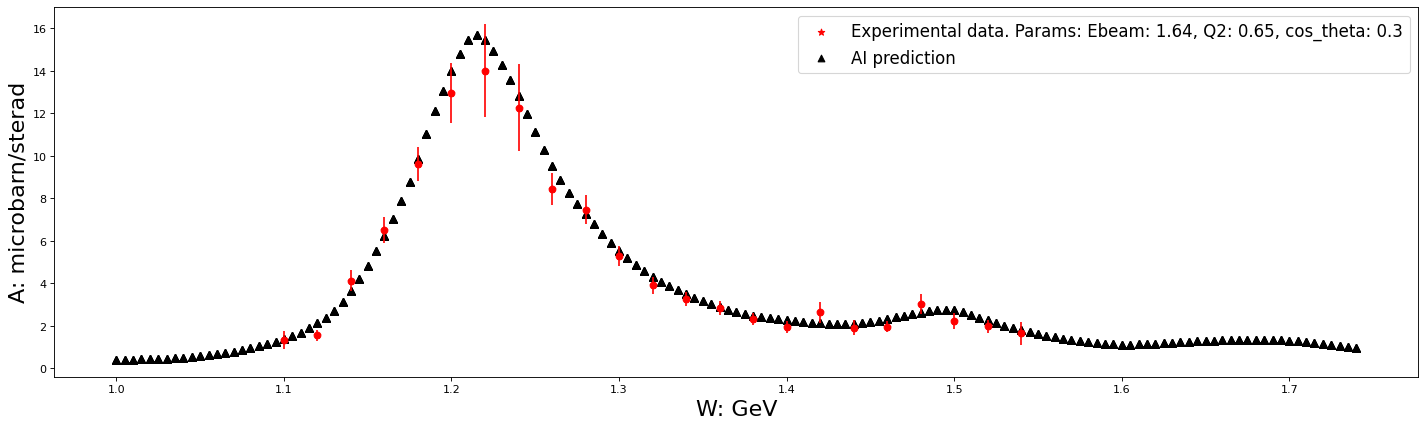

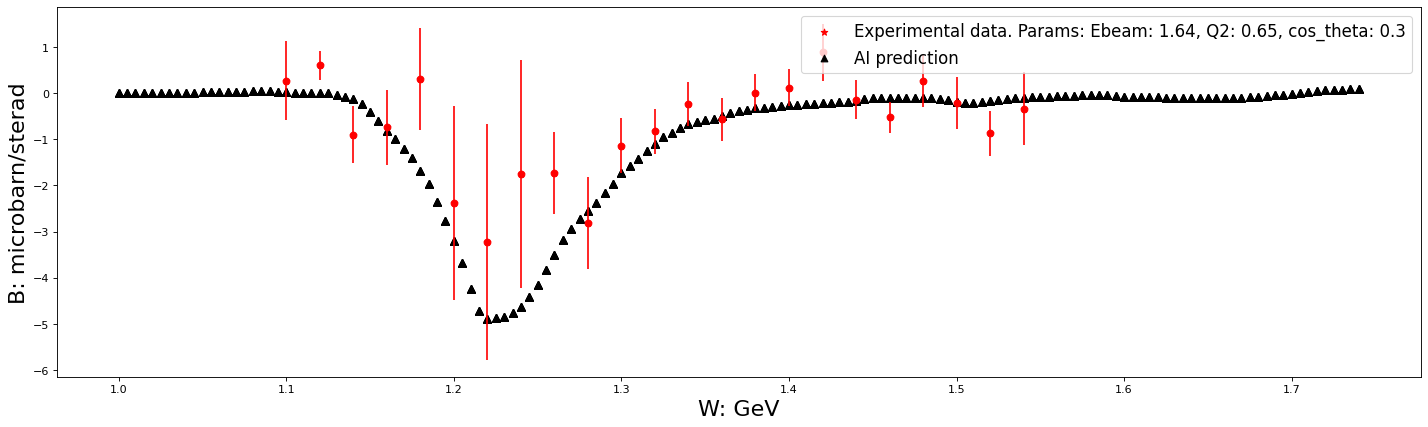

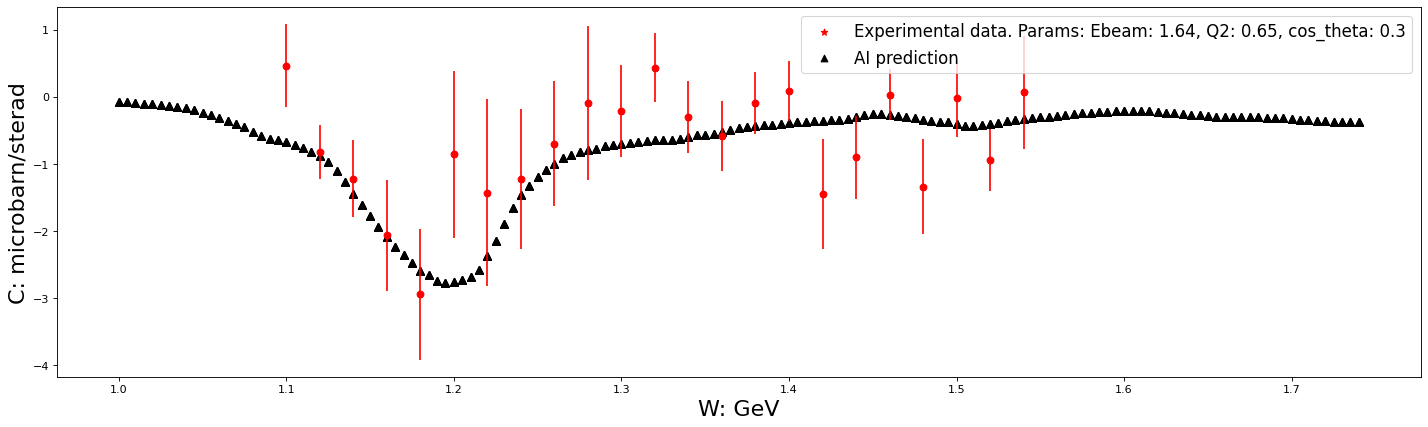

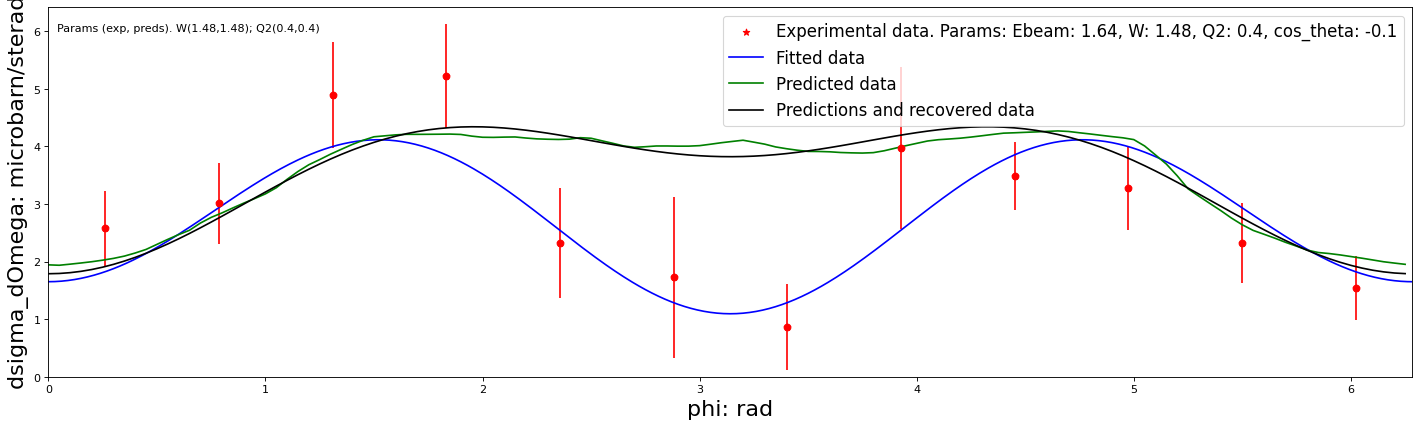

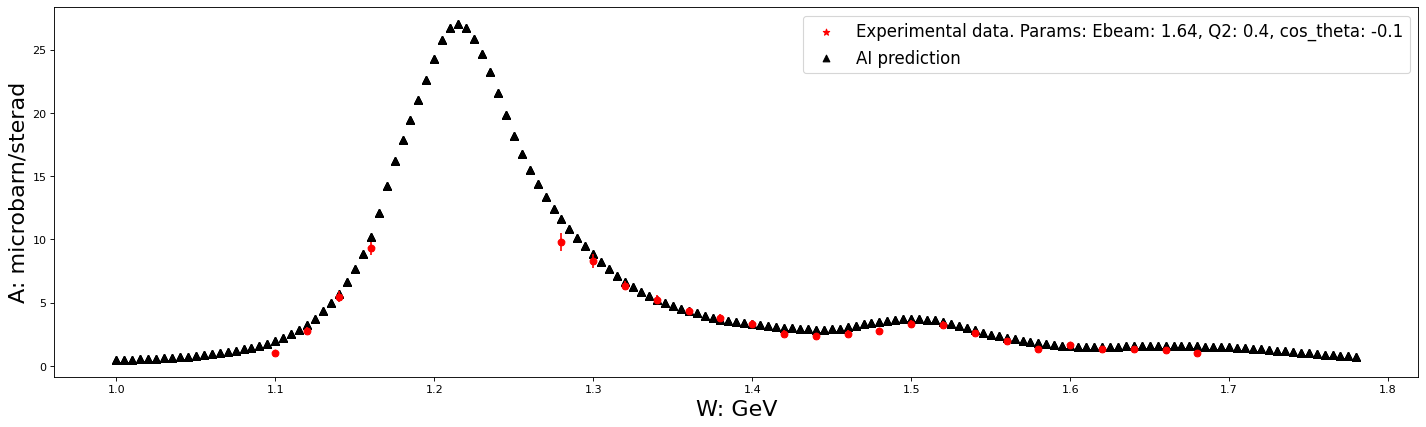

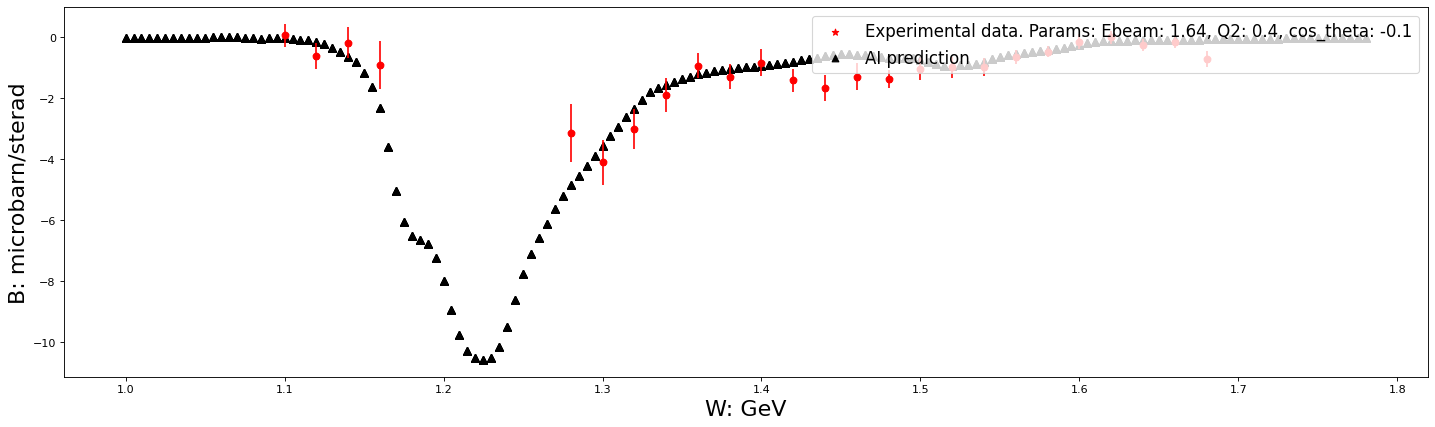

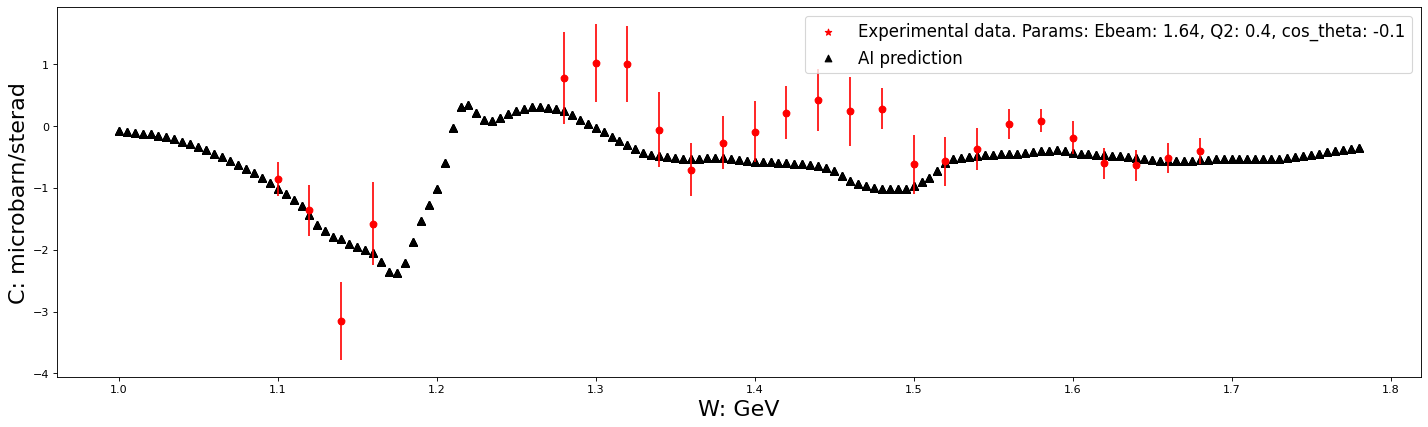

100%|██████████| 157/157 [00:07<00:00, 20.33it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-13-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3274686765693377' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-13-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.023610142332353527' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

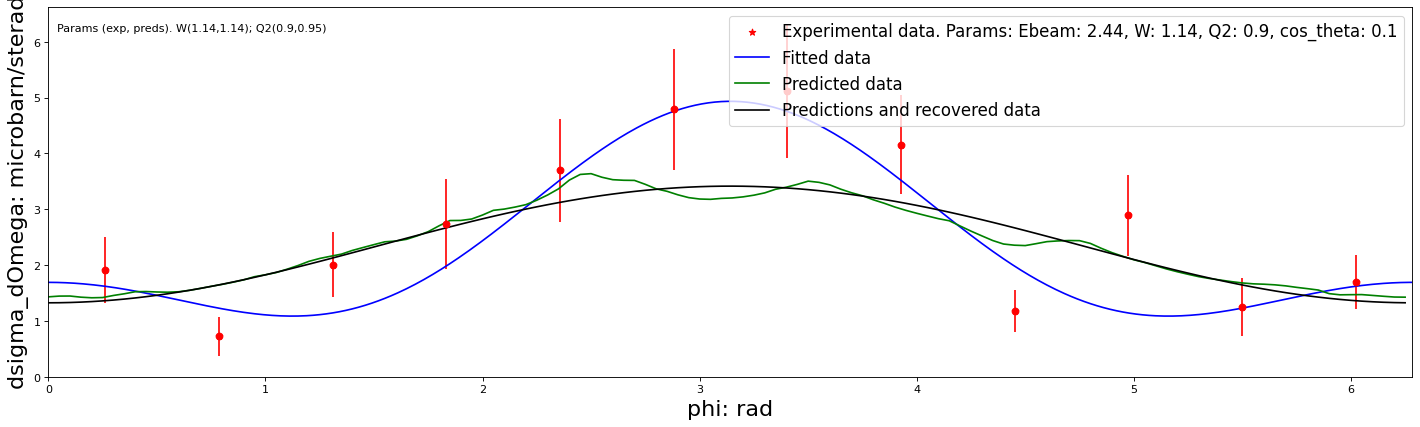

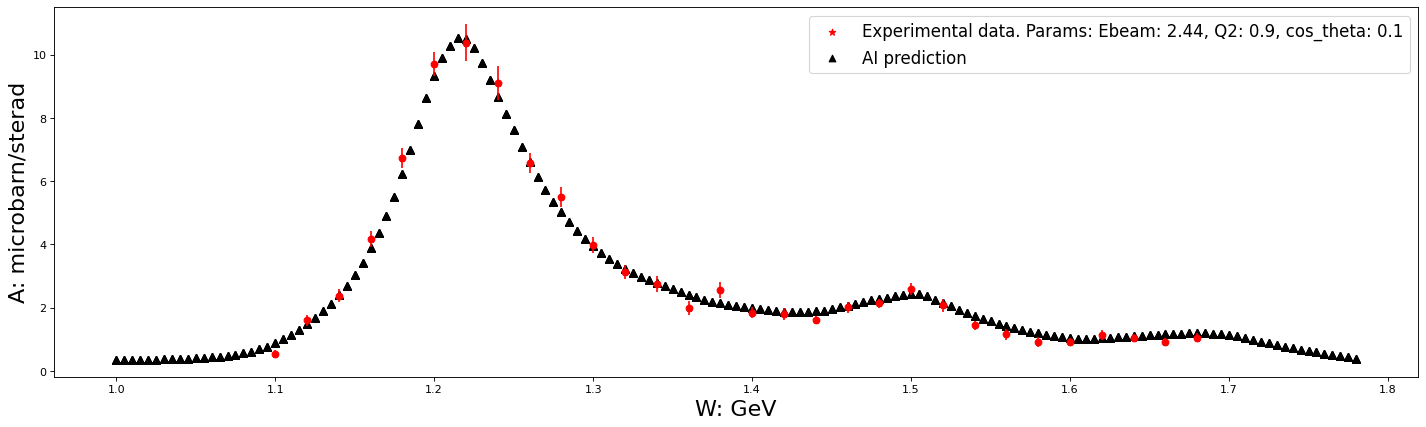

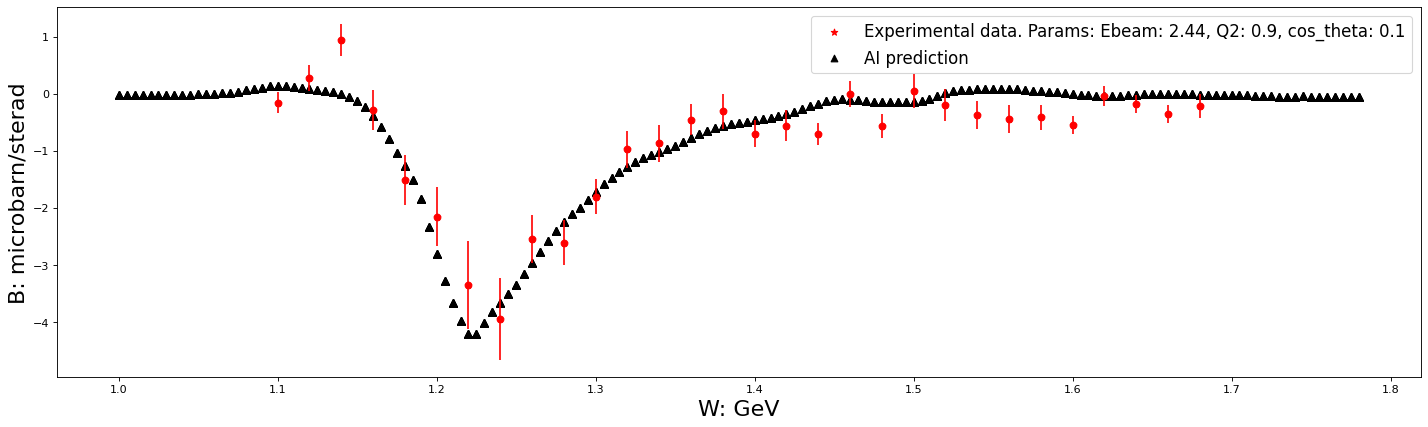

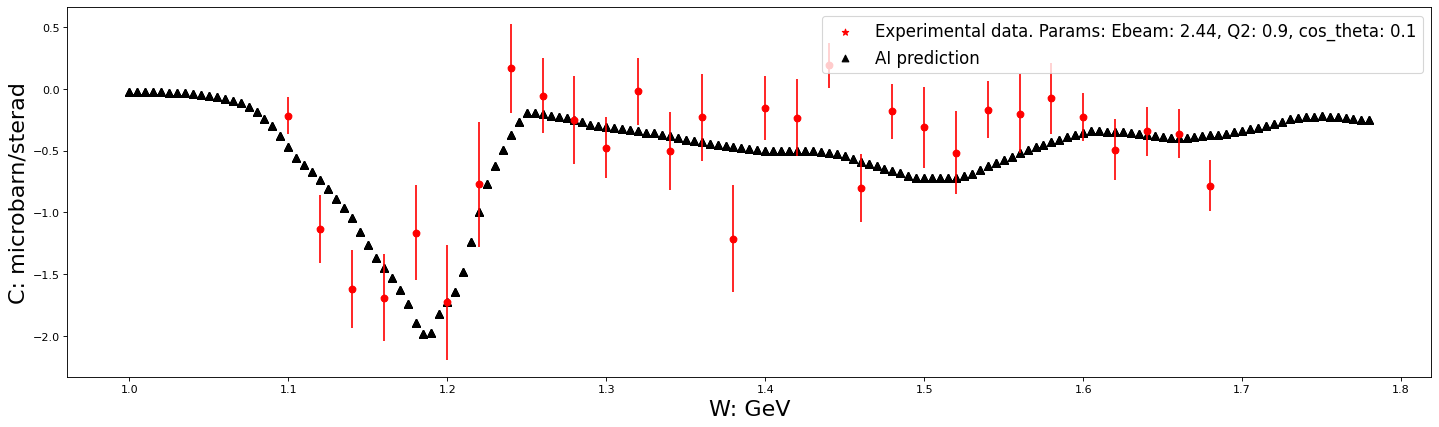

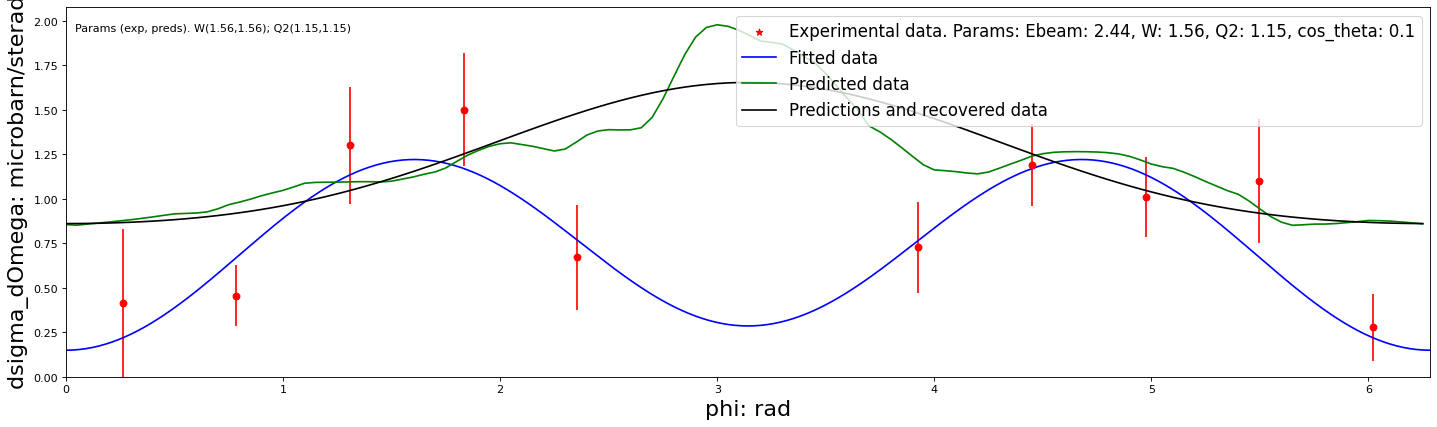

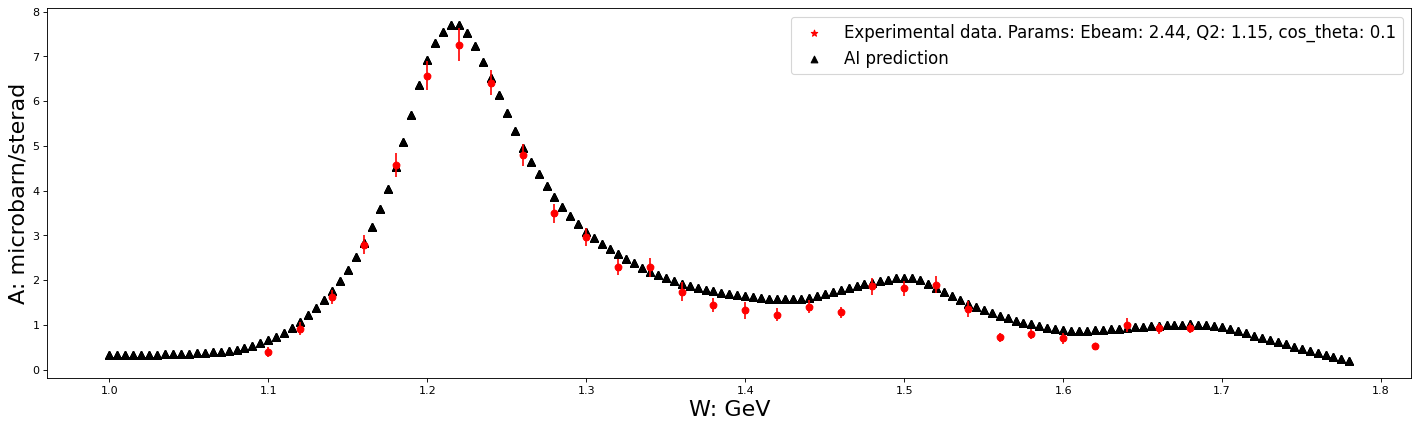

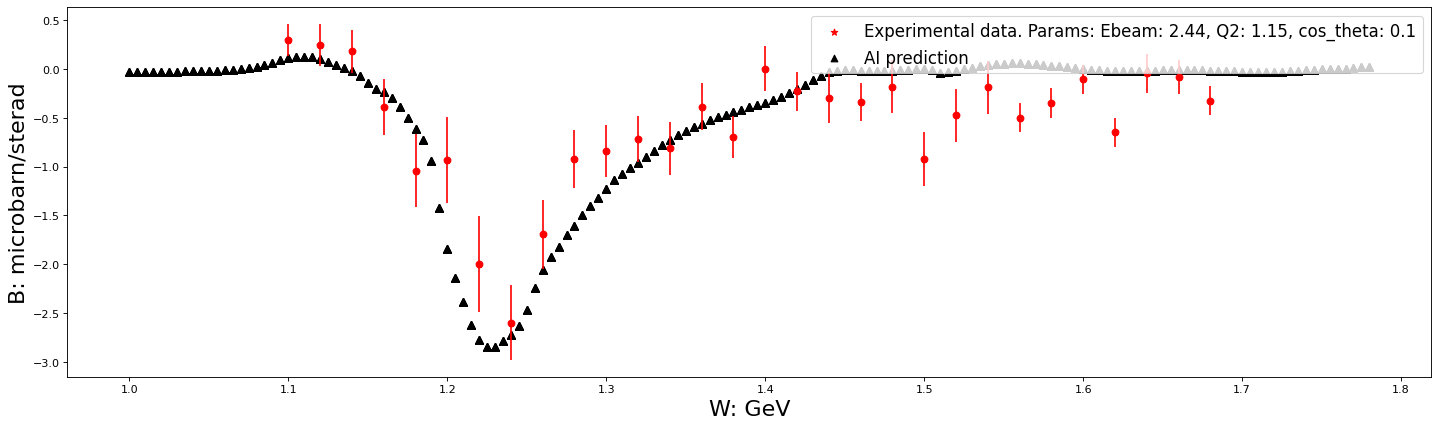

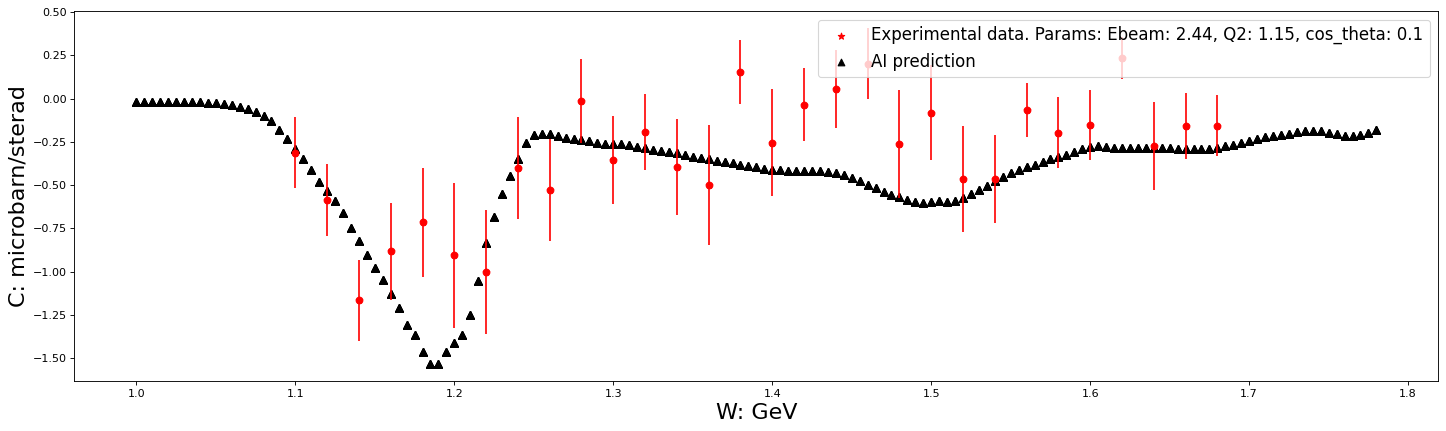

100%|██████████| 97/97 [00:08<00:00, 11.72it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-13-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.05124255984019671' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-13-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.010432784898173723' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-inp

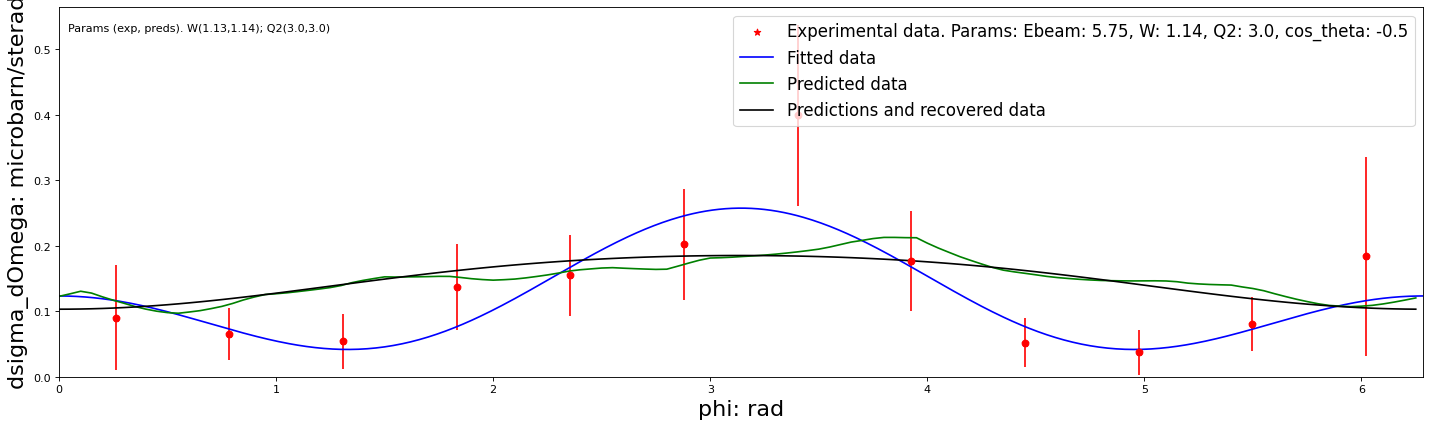

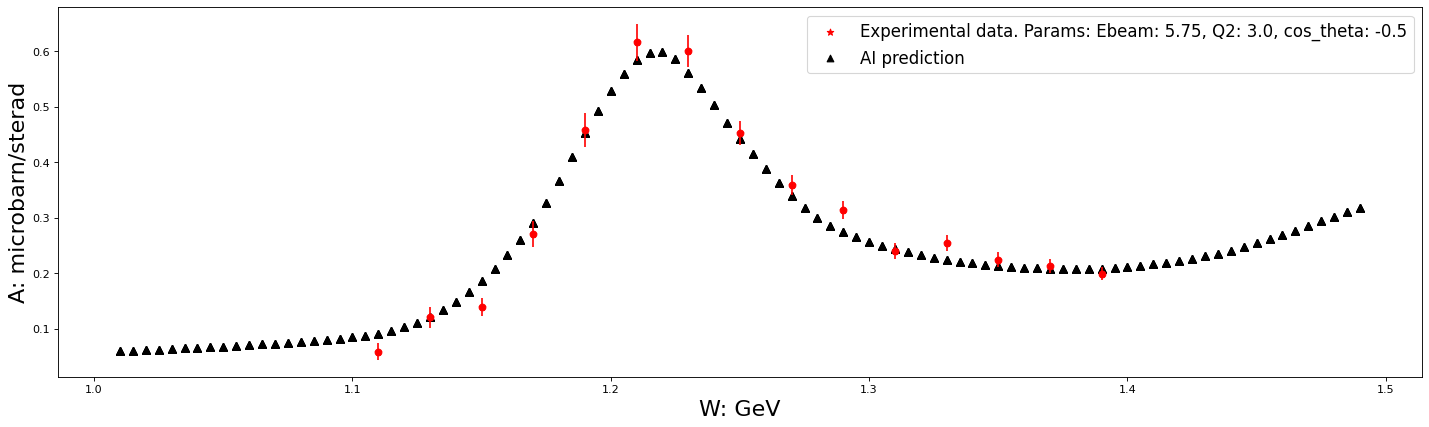

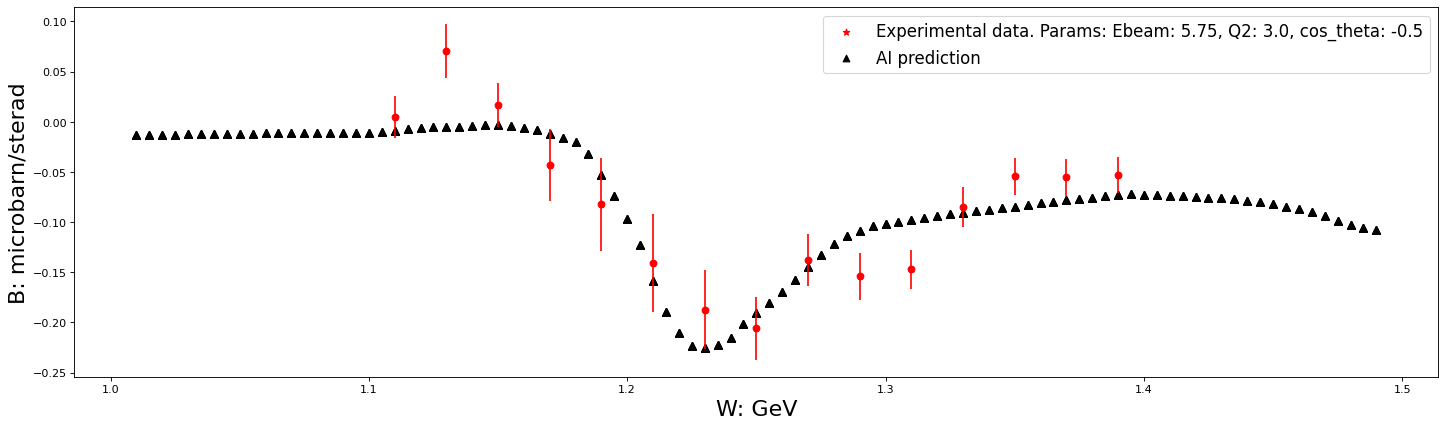

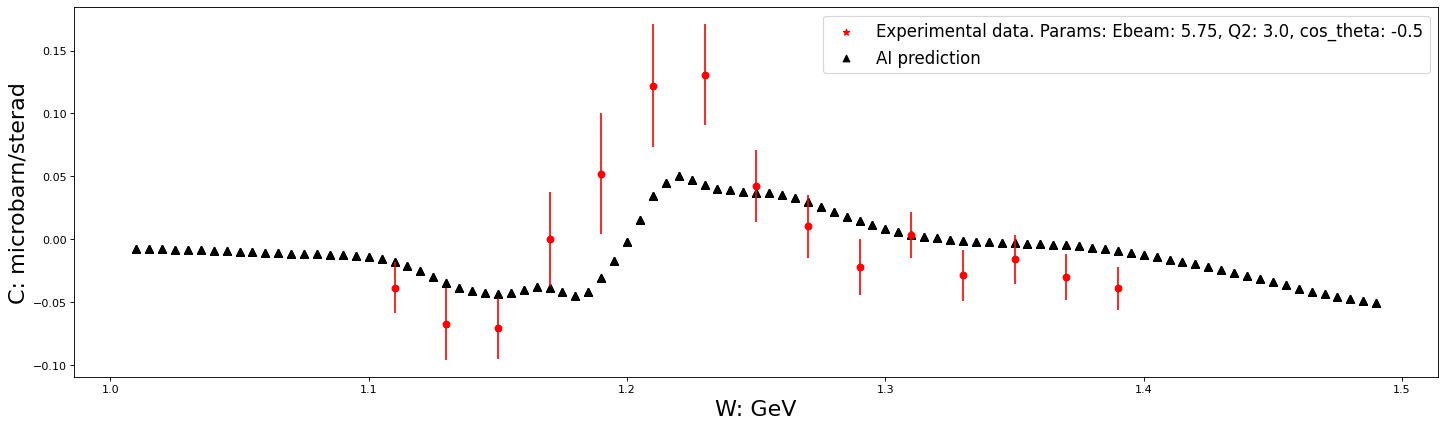

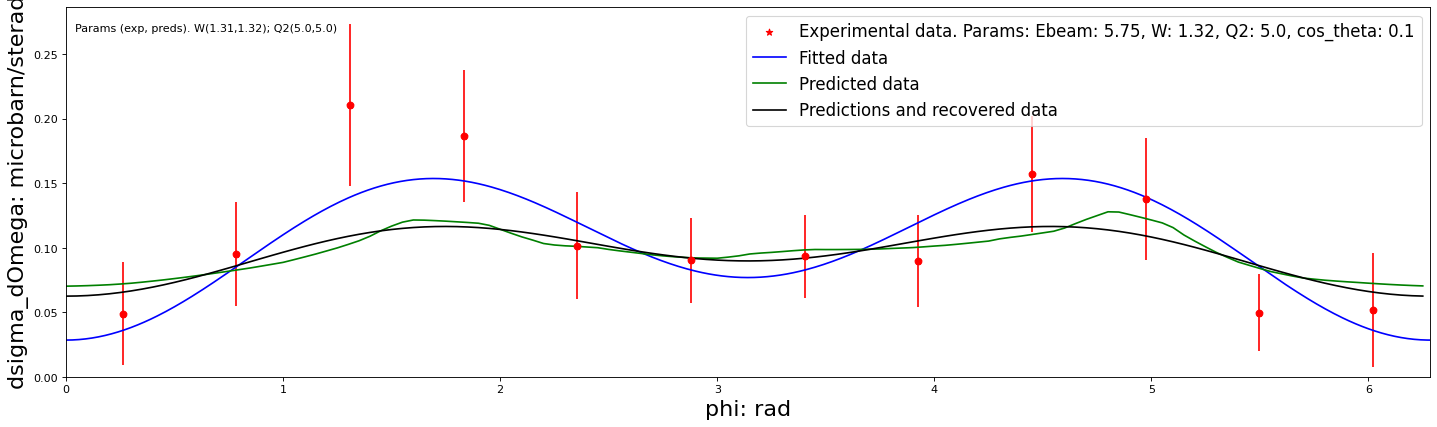

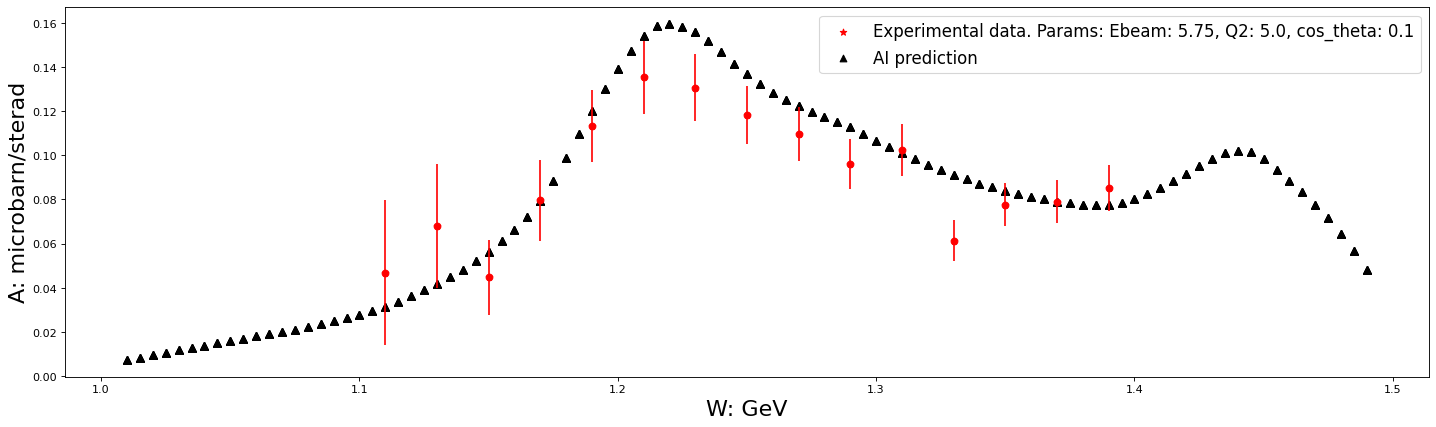

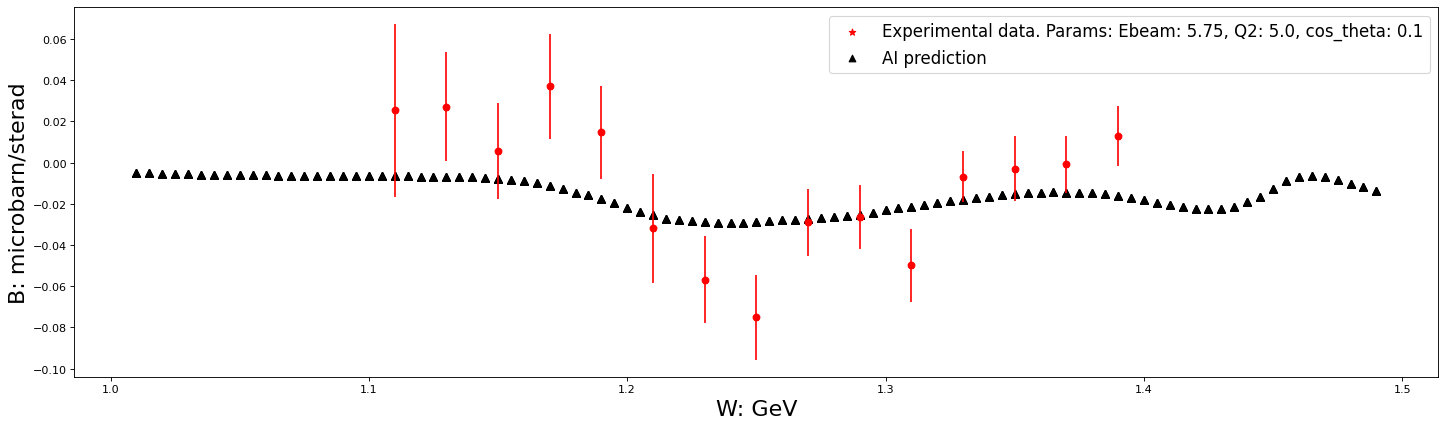

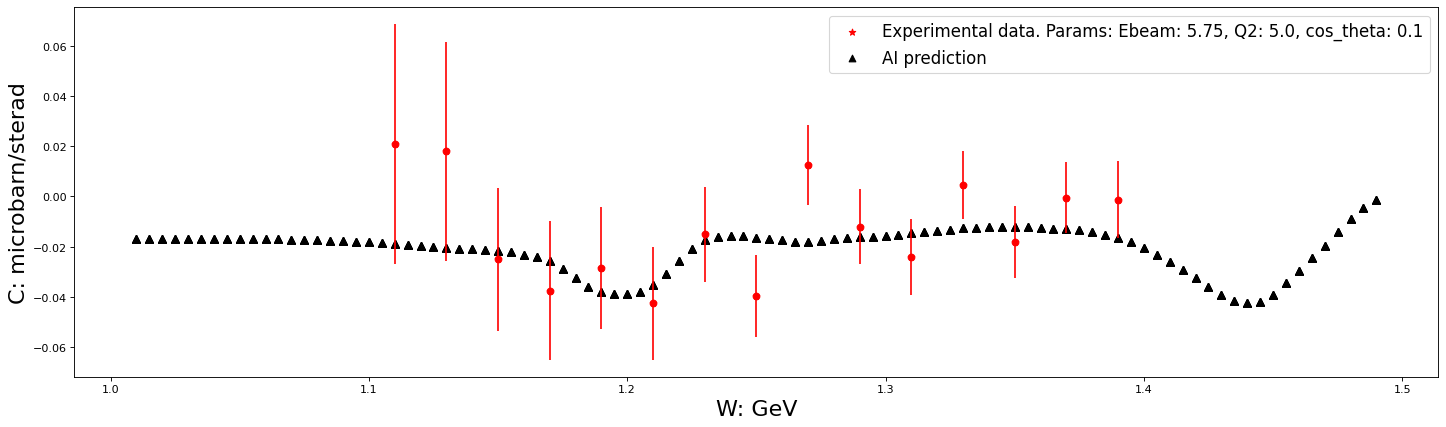

100%|██████████| 177/177 [00:04<00:00, 40.25it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-13-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.30814339624994674' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-13-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.018352832984014418' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-i

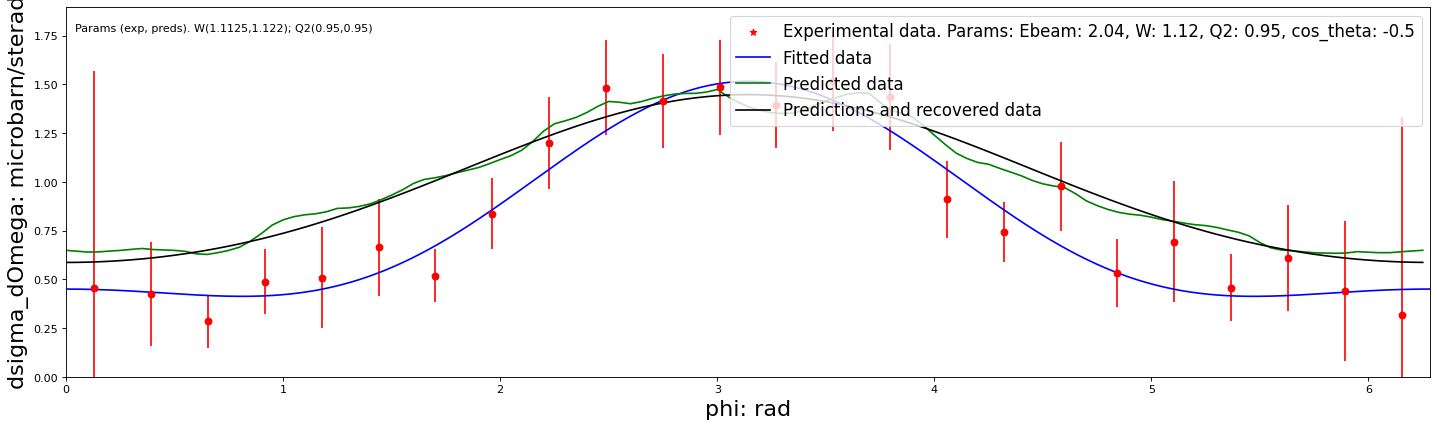

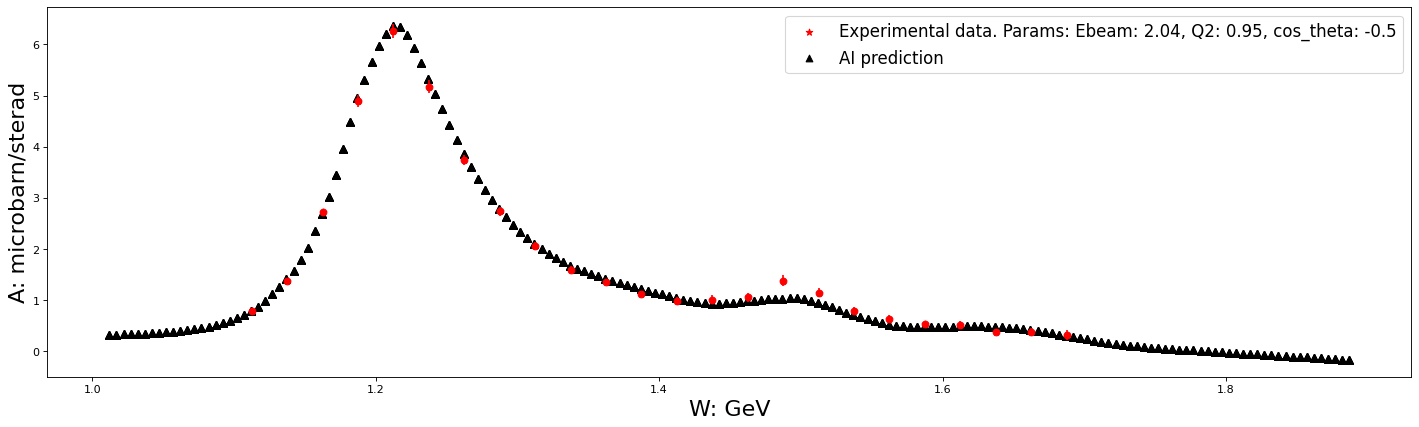

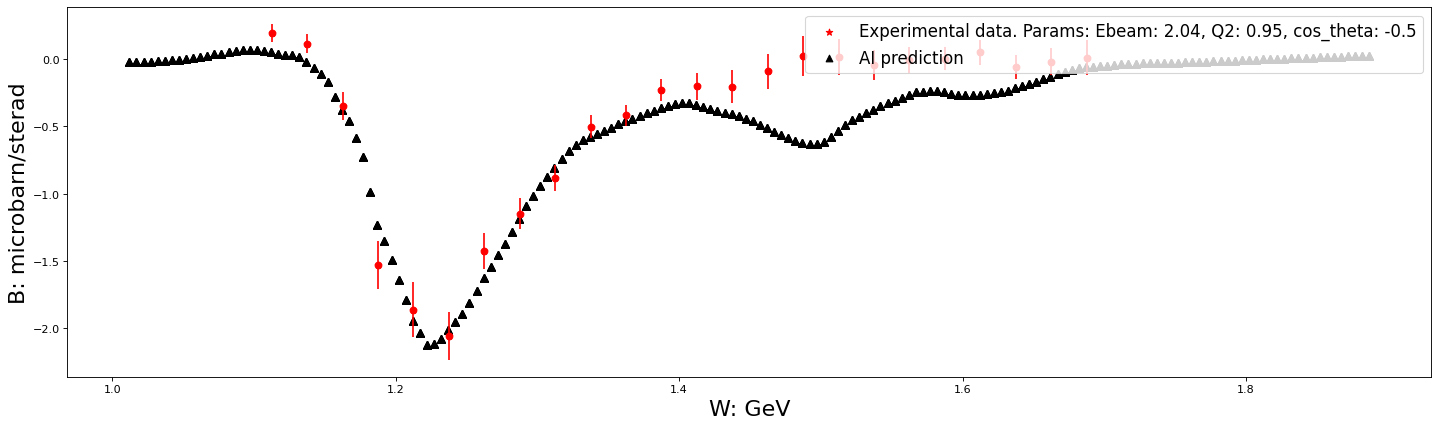

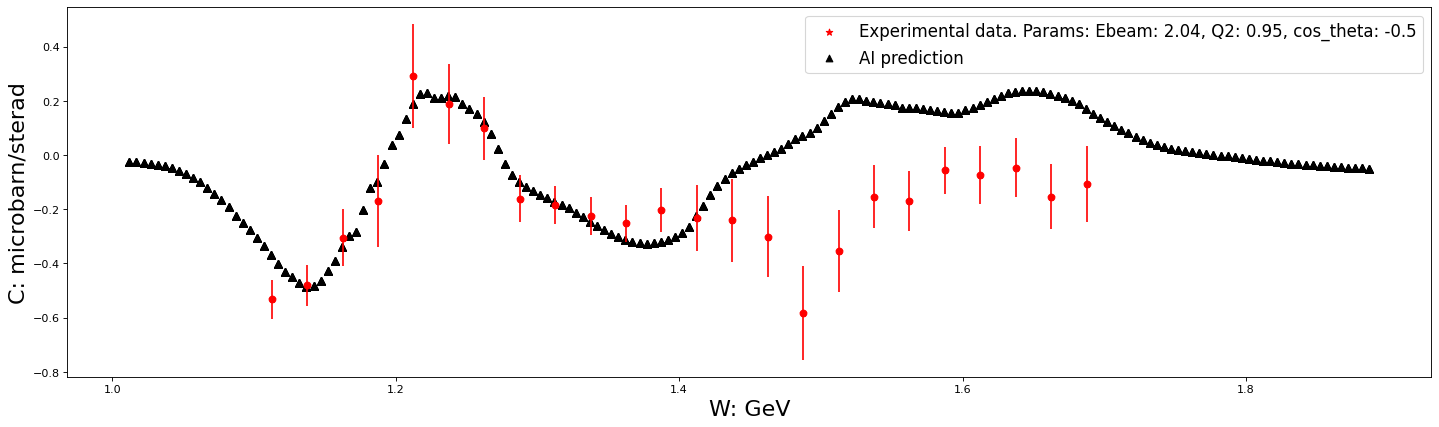

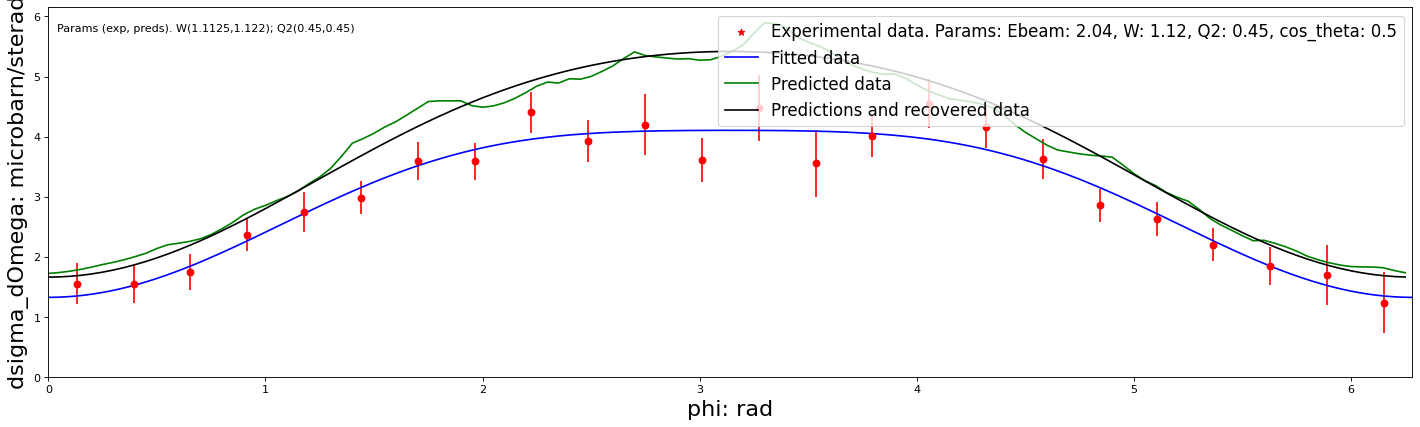

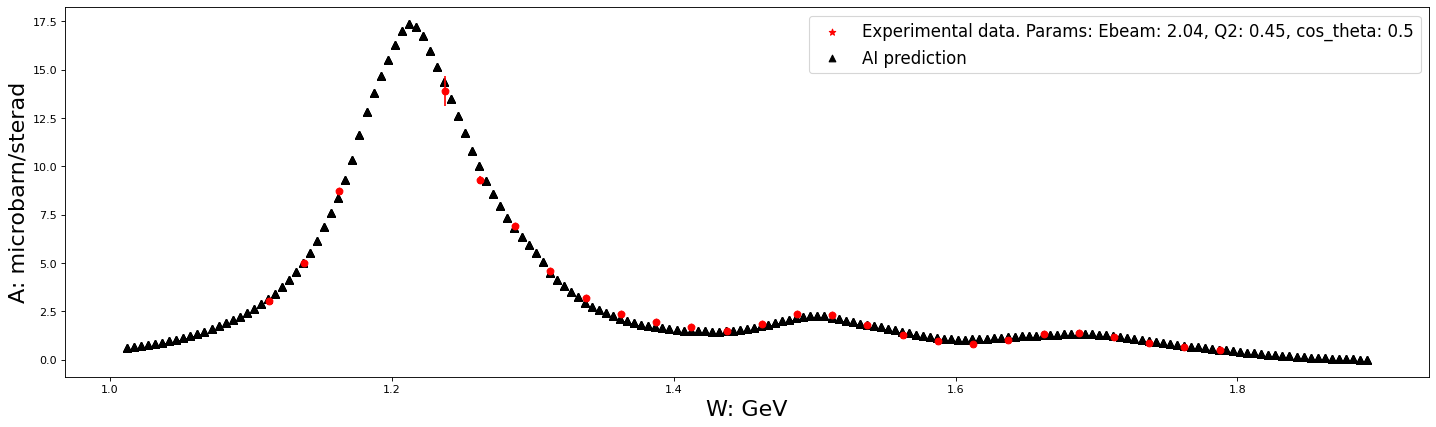

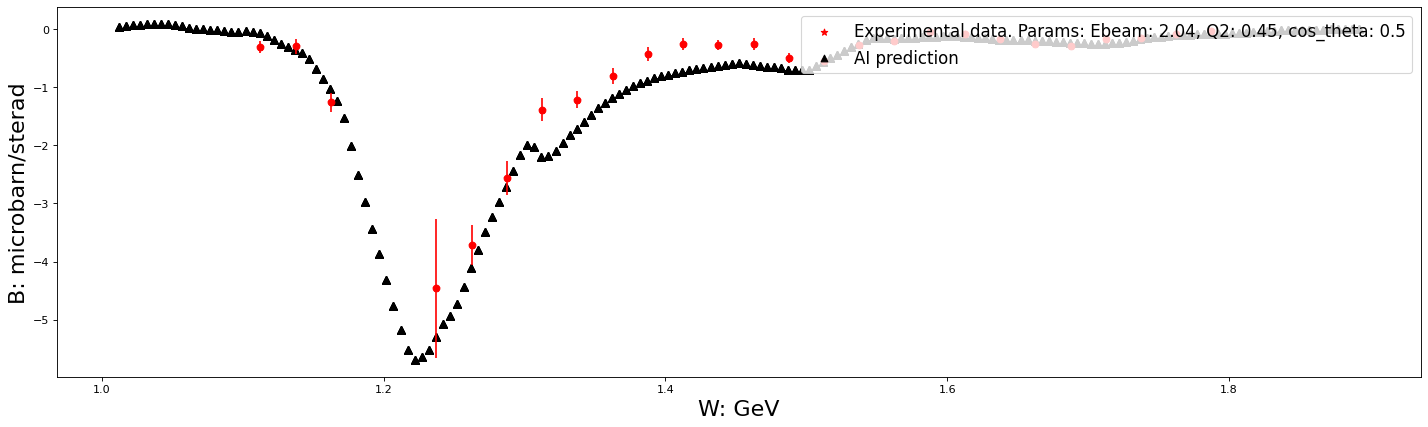

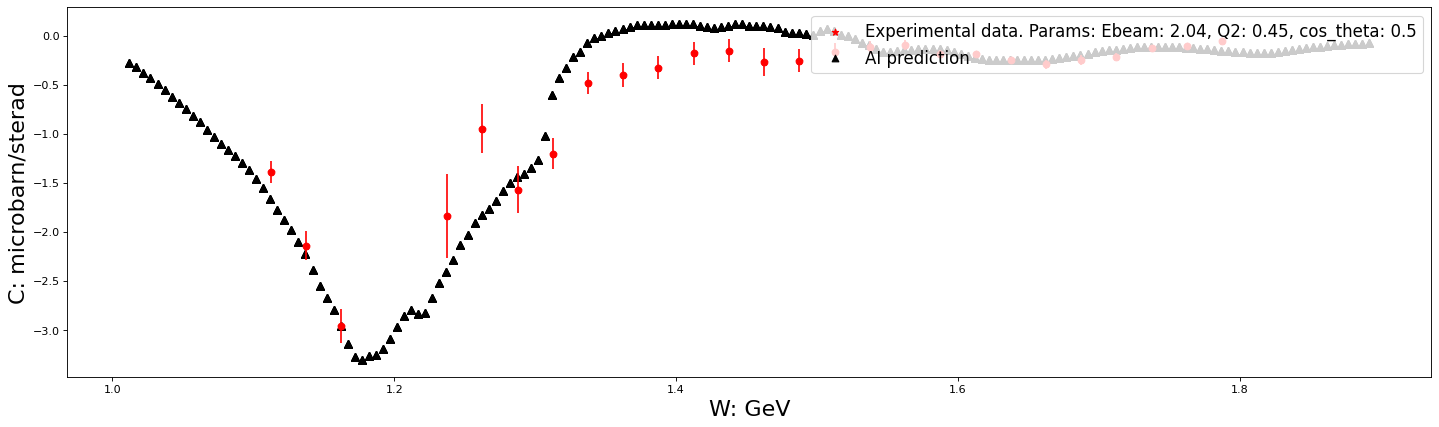

In [15]:
def plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf):
    plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
    return None

for Ebeam in [1.64, 2.44, 5.75, 2.04]:
    os.makedirs(f"/content/NN/E_beam={Ebeam}", exist_ok=True)
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[0]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[0]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[0]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[1]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[1]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[1]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

In [16]:
# Log results to W&B Media

# for root, dirs, files in os.walk(os.path.abspath("/content/NN")):
#     for file in files:
#         path_to_img = os.path.join(root, file)
#         im = plt.imread(path_to_img)
#         wandb.log({"img": [wandb.Image(path_to_img)]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})

2024-12-11 15:18:57,419 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 15:18:57,422 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 15:18:57,425 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 15:18:57,427 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-11 15:18:57,459 : DEBUG : Starting new HTTPS connection (1): api.wandb.ai:443
2024-12-11 15:18:57,512 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-11 15:18:57,553 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-11 15:18:57,566 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 15:18:57,568 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 15:18:57,570 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 15:18:57,573 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-11 15:18:57,602 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 15:18:57,608 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 15:18:57,611 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 15:18:57,614 : DEBUG : STREAM b'IDAT' 131 38091
2024-12-11 15:18:57,646 : DEBUG : STREAM b'IHDR' 16 13
202

In [17]:
# Log results to W&B Artifacts

wandb_table = wandb.Table(columns=["Ebeam", "cross section","A","B","C"])


for root, dirs, files in os.walk(os.path.abspath("/content/NN//E_beam=1.64")):
    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'))

    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.04")):
    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'))

    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.44")):
    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'))

    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=5.75")):
    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'))

    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'))



# Create a wandb Artifact
artifact = wandb.Artifact(name="plots", type="data")
# Add the table to the artifact
#artifact.add(wandb.Image(path_to_img), "plots_E_beam={Ebeam}")
artifact.add(wandb_table, f"plots")
# Log the artifact
wandb.log_artifact(artifact)

2024-12-11 15:19:01,230 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 15:19:01,235 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 15:19:01,239 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 15:19:01,244 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-11 15:19:01,285 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 15:19:01,288 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 15:19:01,292 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 15:19:01,296 : DEBUG : STREAM b'IDAT' 131 38091
2024-12-11 15:19:01,319 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 15:19:01,322 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 15:19:01,325 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 15:19:01,327 : DEBUG : STREAM b'IDAT' 131 36226
2024-12-11 15:19:01,361 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 15:19:01,366 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 15:19:01,371 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 15:19:01,374 : DEBUG : STREAM b'IDAT' 131 36280
2024-12-11 15:19:01,411 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 15:19:01,416 : DEBUG : STREAM b'tEXt' 

<Artifact plots>

In [18]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_scheduler_monitoring,████▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇▇▇████████████████████████████████████
train_rmse,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▃▁▁▁▃▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▄▂▄▂▂▂▃▁▅▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▃▁▂▁▁▁▂▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 157/157 [00:04<00:00, 33.75it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-7-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3846924947271446' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-7-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.006029384299421474' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input

2024-12-03 16:02:50,100 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-03 16:02:50,103 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-03 16:02:50,106 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-12-03 16:02:50,109 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-03 16:02:50,111 : DEBUG : findfont: sc

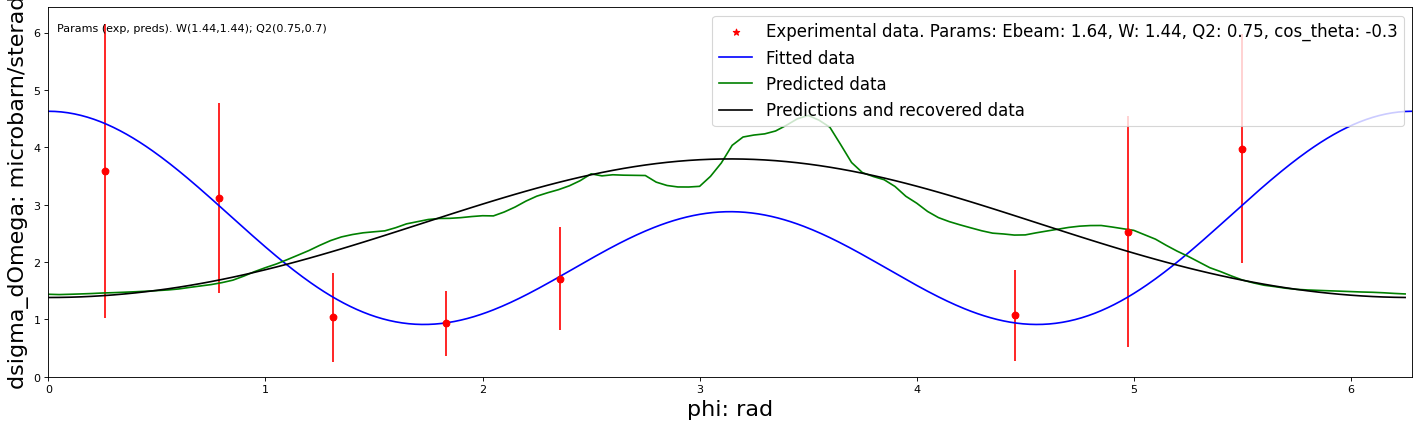

2024-12-03 16:02:52,649 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:52,651 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:52,653 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:52,655 : DEBUG : STREAM b'IDAT' 131 36433
2024-12-03 16:02:52,787 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:52,790 : DEBUG : STREAM b'IDAT' 41 36433


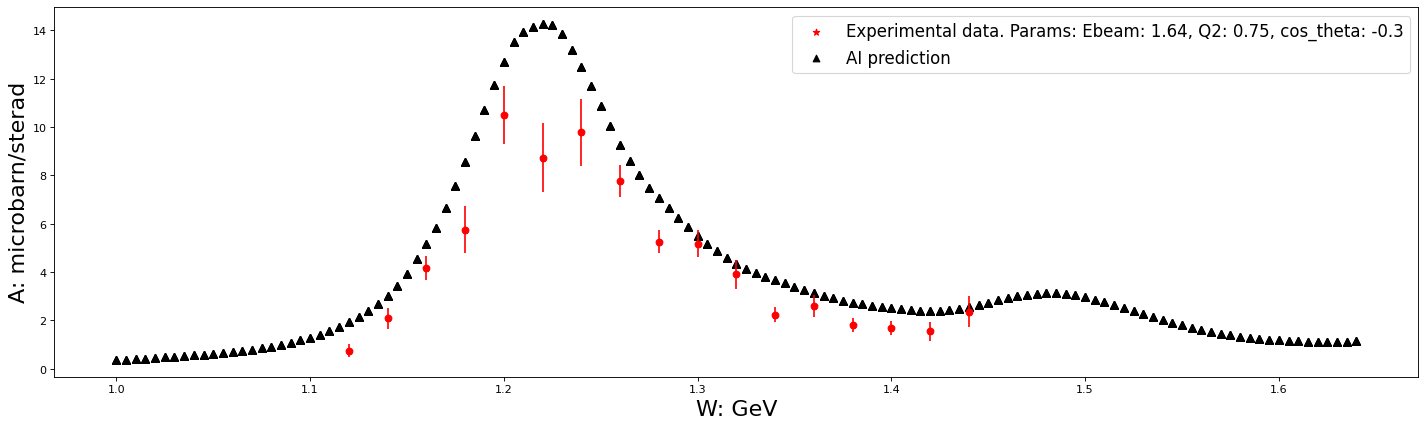

2024-12-03 16:02:53,850 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:53,852 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:53,854 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:53,856 : DEBUG : STREAM b'IDAT' 131 35982
2024-12-03 16:02:53,938 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:53,940 : DEBUG : STREAM b'IDAT' 41 35982


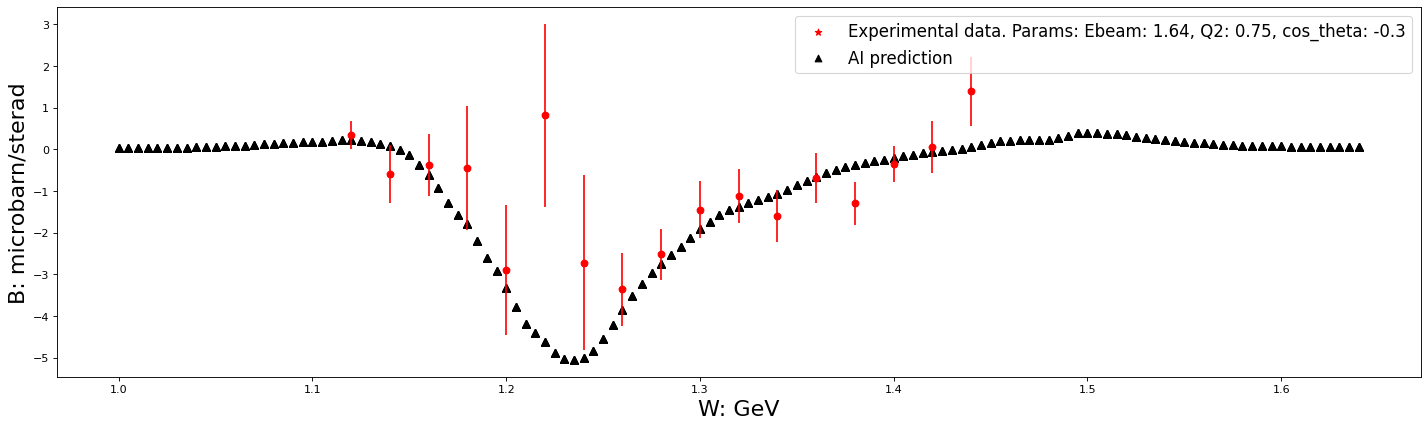

2024-12-03 16:02:54,613 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:54,615 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:54,617 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:54,620 : DEBUG : STREAM b'IDAT' 131 36865
2024-12-03 16:02:54,704 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:54,706 : DEBUG : STREAM b'IDAT' 41 36865


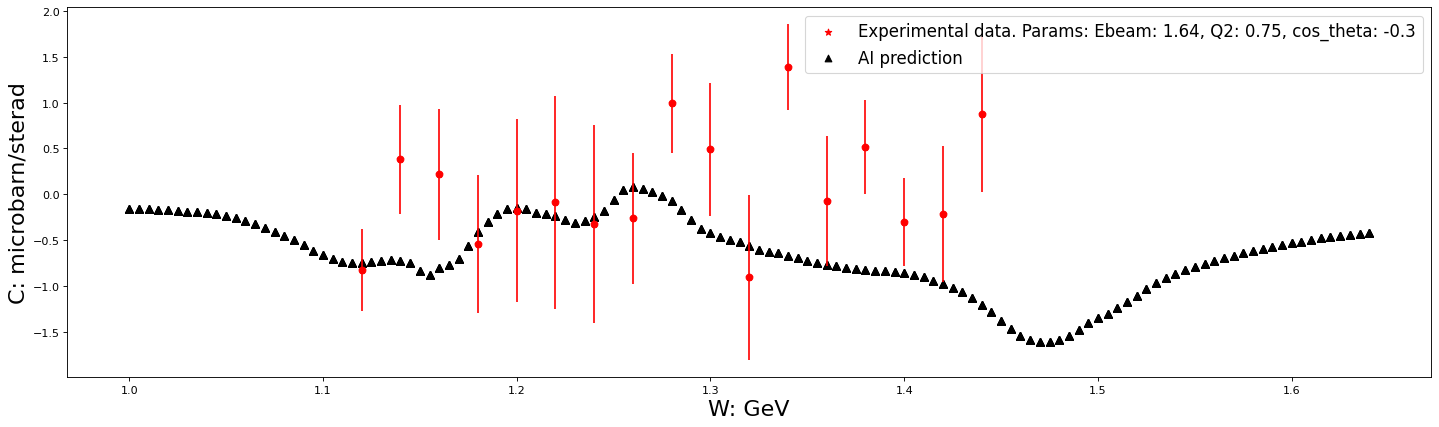

1
2024-12-03 16:02:55,385 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:55,387 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:55,390 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:55,394 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:02:55,485 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:55,488 : DEBUG : STREAM b'IDAT' 41 65536


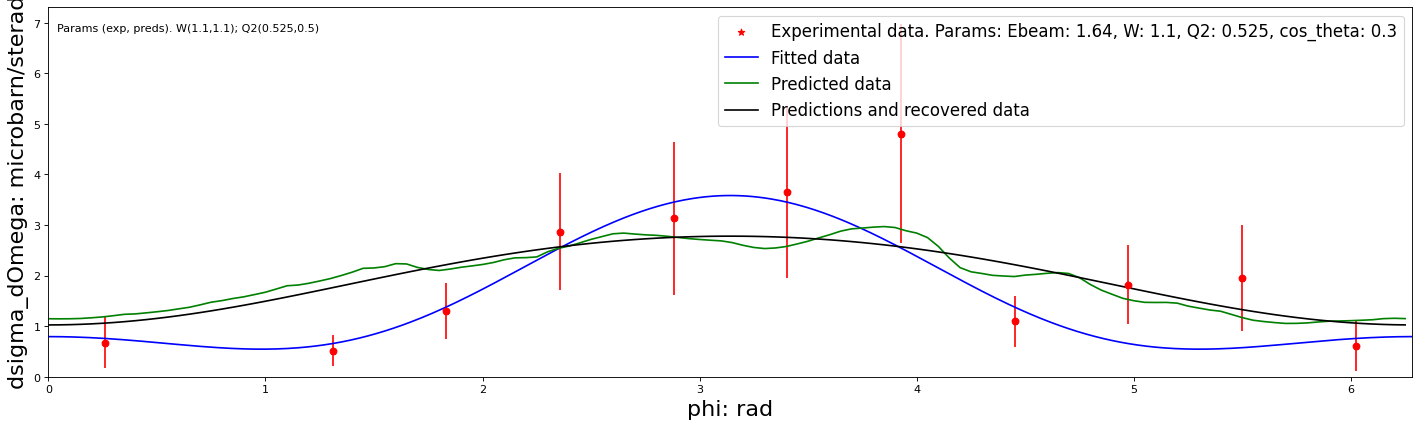

2024-12-03 16:02:56,183 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,185 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:56,191 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:56,195 : DEBUG : STREAM b'IDAT' 131 37516
2024-12-03 16:02:56,292 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,295 : DEBUG : STREAM b'IDAT' 41 37516


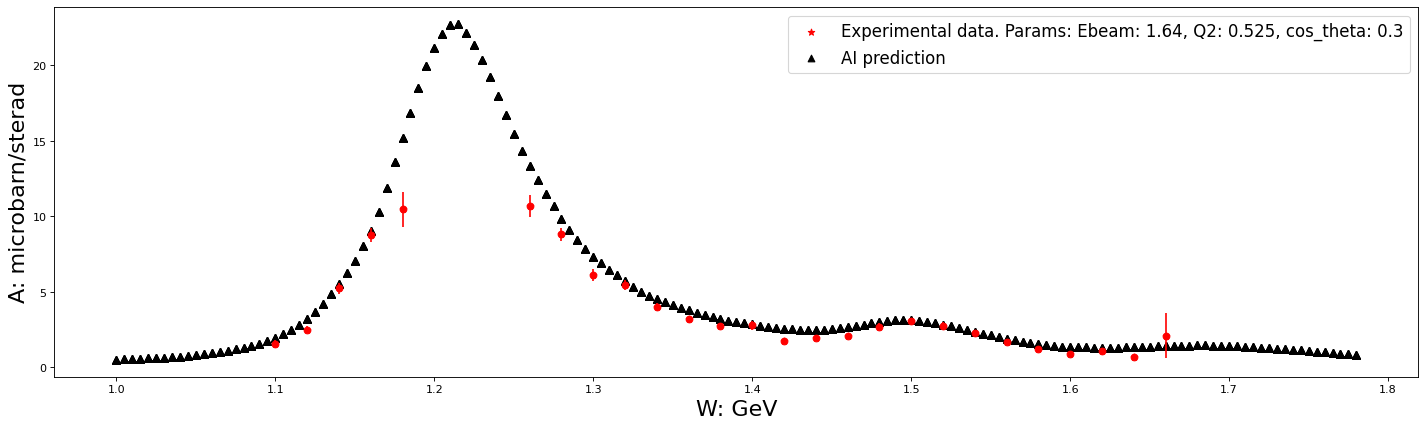

2024-12-03 16:02:56,996 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,998 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:57,000 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:57,002 : DEBUG : STREAM b'IDAT' 131 36214
2024-12-03 16:02:57,084 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,086 : DEBUG : STREAM b'IDAT' 41 36214


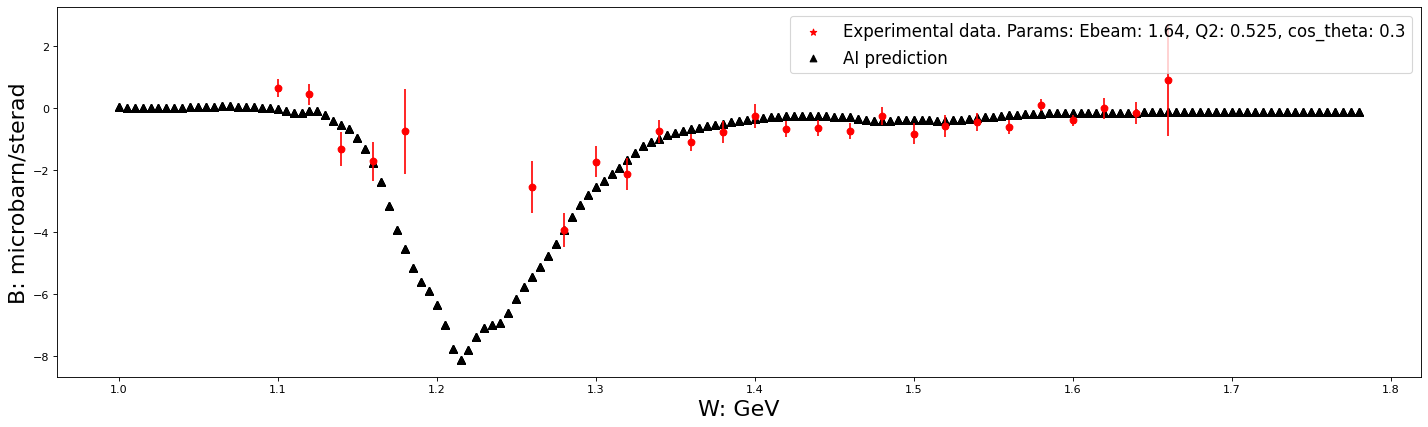

2024-12-03 16:02:57,790 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,792 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:57,795 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:57,798 : DEBUG : STREAM b'IDAT' 131 36991
2024-12-03 16:02:57,884 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,886 : DEBUG : STREAM b'IDAT' 41 36991


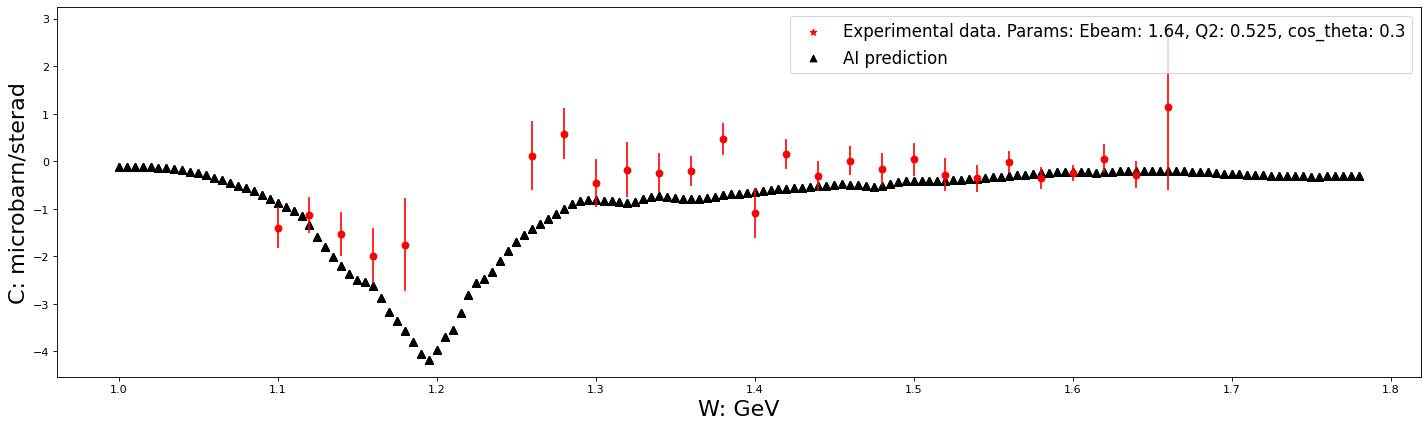

2


100%|██████████| 157/157 [00:07<00:00, 21.75it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-7-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3759944385466103' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-7-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06444017856602151' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input-

2024-12-03 16:17:39,521 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:39,522 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:39,525 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:39,528 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:17:39,644 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:39,647 : DEBUG : STREAM b'IDAT' 41 65536


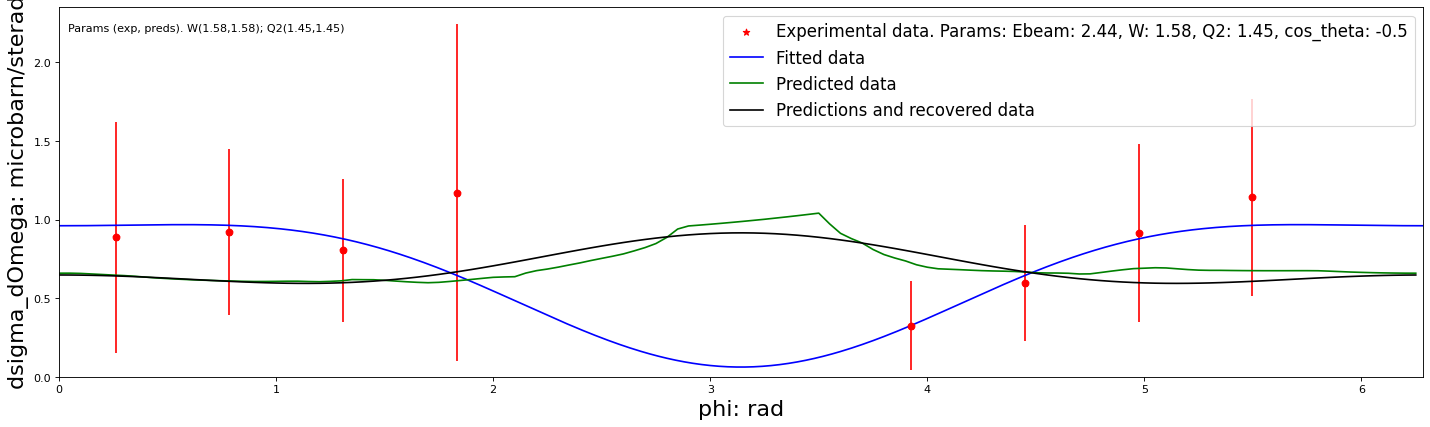

2024-12-03 16:17:40,530 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:40,533 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:40,535 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:40,537 : DEBUG : STREAM b'IDAT' 131 39649
2024-12-03 16:17:40,633 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:40,636 : DEBUG : STREAM b'IDAT' 41 39649


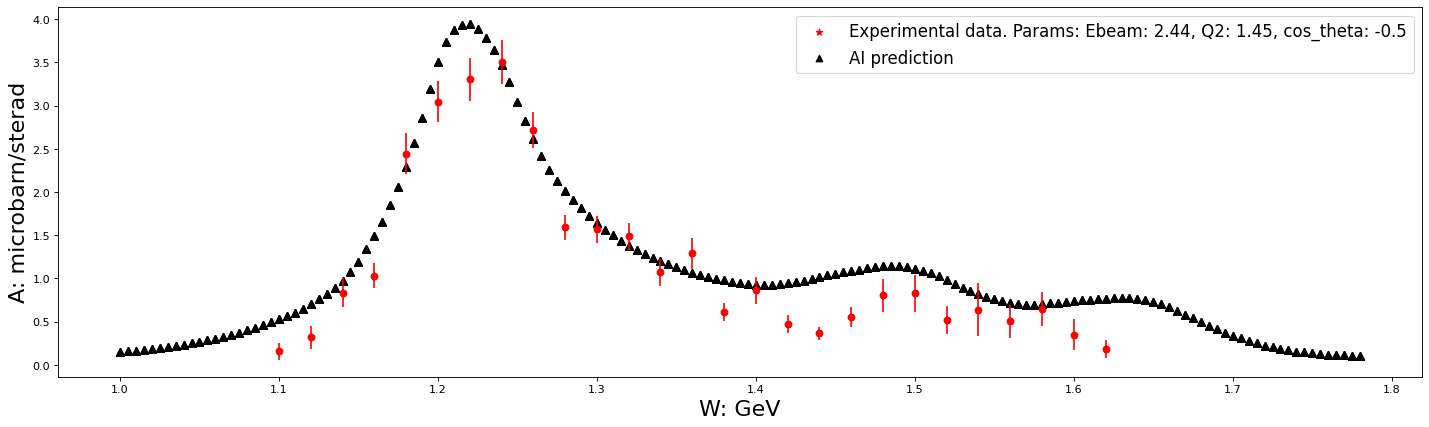

2024-12-03 16:17:41,532 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:41,534 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:41,537 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:41,539 : DEBUG : STREAM b'IDAT' 131 39774
2024-12-03 16:17:41,635 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:41,641 : DEBUG : STREAM b'IDAT' 41 39774


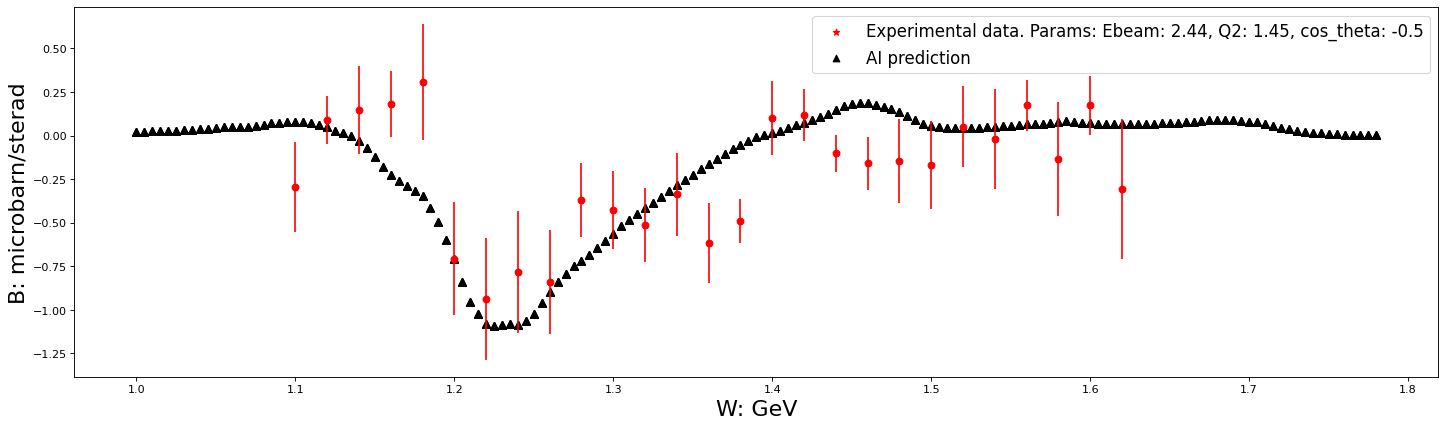

2024-12-03 16:17:42,570 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:42,574 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:42,576 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:42,579 : DEBUG : STREAM b'IDAT' 131 40327
2024-12-03 16:17:42,675 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:42,677 : DEBUG : STREAM b'IDAT' 41 40327


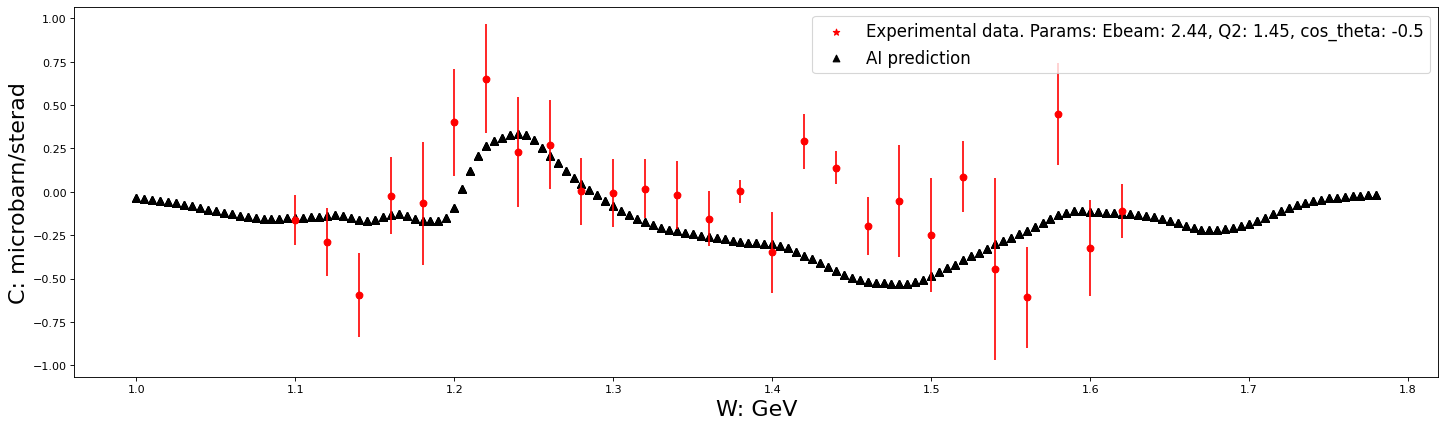

1
2024-12-03 16:17:43,580 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:43,582 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:43,585 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:43,588 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:17:43,687 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:43,692 : DEBUG : STREAM b'IDAT' 41 65536


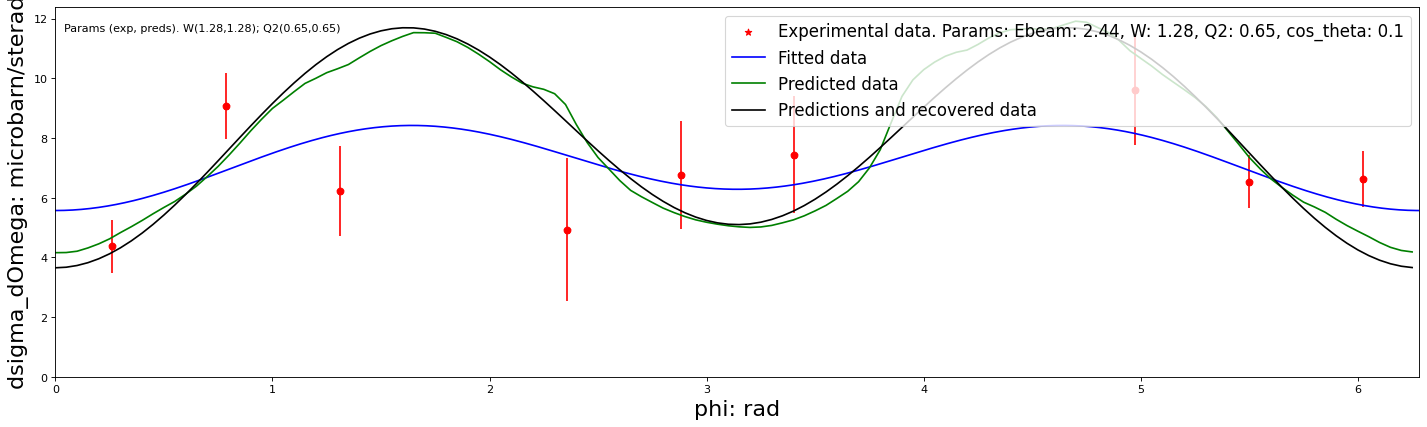

2024-12-03 16:17:44,586 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:44,589 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:44,591 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:44,594 : DEBUG : STREAM b'IDAT' 131 39500
2024-12-03 16:17:44,691 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:44,693 : DEBUG : STREAM b'IDAT' 41 39500


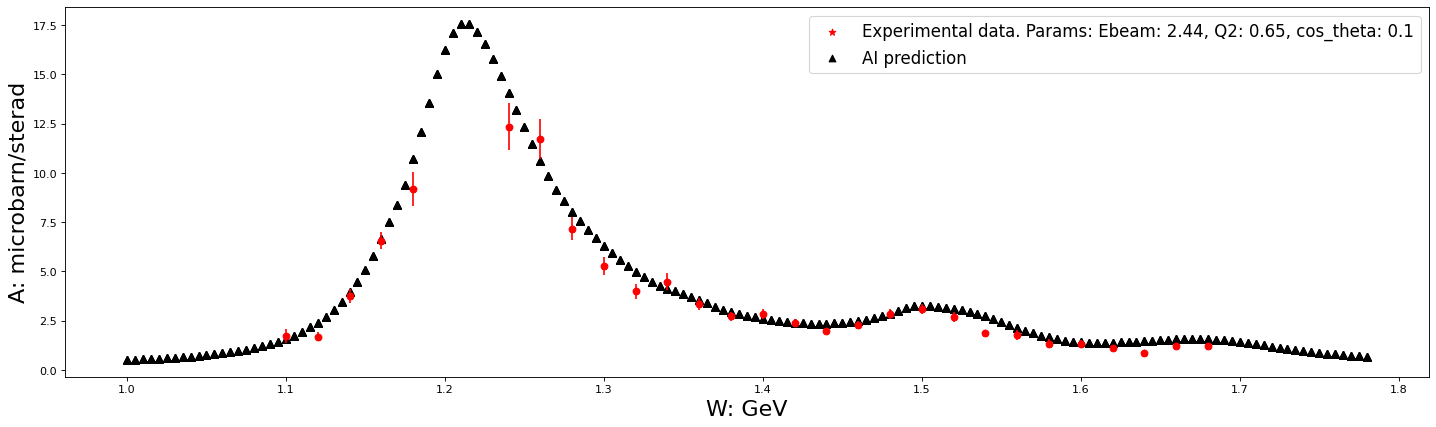

2024-12-03 16:17:45,591 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:45,593 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:45,596 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:45,599 : DEBUG : STREAM b'IDAT' 131 36530
2024-12-03 16:17:45,692 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:45,694 : DEBUG : STREAM b'IDAT' 41 36530


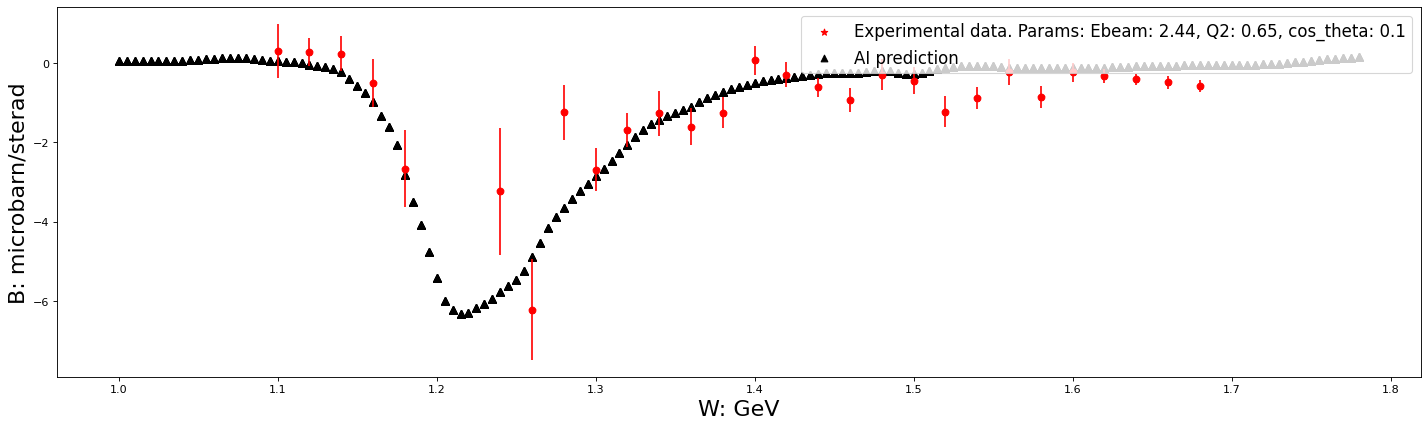

2024-12-03 16:17:46,823 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:46,828 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:46,830 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:46,833 : DEBUG : STREAM b'IDAT' 131 39694
2024-12-03 16:17:46,983 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:46,988 : DEBUG : STREAM b'IDAT' 41 39694


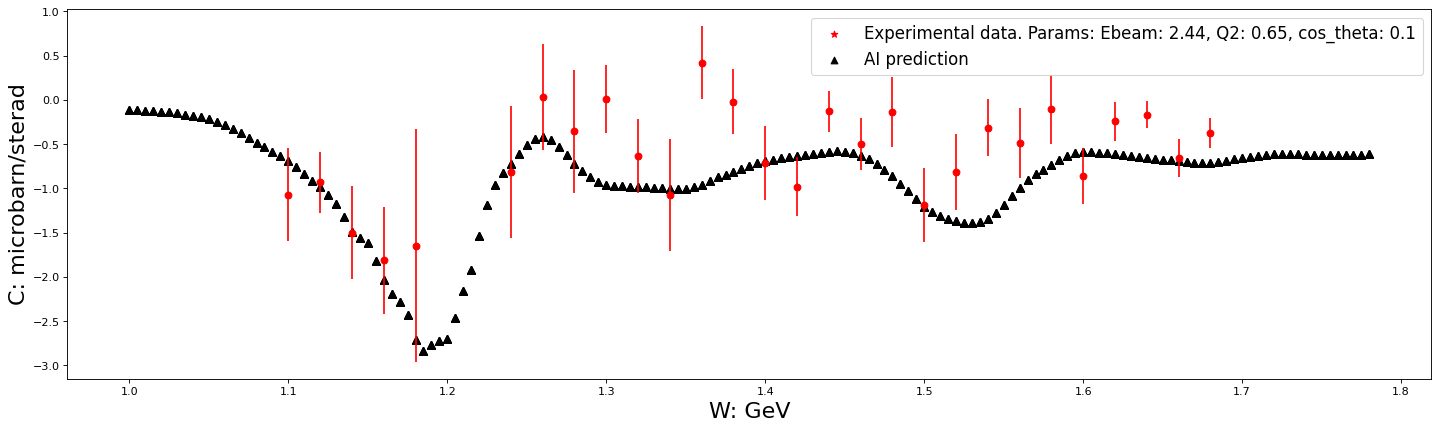

2


100%|██████████| 97/97 [00:09<00:00, 10.48it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
 24%|██▍       | 24/100 [04:08<13:07, 10.36s/it]


KeyboardInterrupt: 

In [ ]:
# #for random choice cross sections and structure functions
# os.makedirs(f"/content/NN/cross_sections", exist_ok=True)
# os.makedirs(f"/content/NN/structure_functions", exist_ok=True)
# for Ebeam in [1.64, 2.44, 5.75, 2.04]:
#     df_grid = generate_grid_df(Ebeam)
#     df_sf = generate_df_sf(Ebeam)
#     step = 0
#     while step != 2:
#         picture_is_not_drawn = True
#         while picture_is_not_drawn:
#             Q2 = random.choice(df[df.Ebeam==Ebeam].Q2.unique())
#             W = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2)].W.unique())
#             cos_theta = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2) & (df.W==W)].cos_theta.unique())
#             try:
#                 plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
#             except:
#                 print(Ebeam, W, Q2, cos_theta)
#             else:
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
#                 step += 1
#                 picture_is_not_drawn = False